In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import random
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020r
from source.python.cnn.models import Zrimec2020c
from source.python.cnn.models import Washburn2019r
from source.python.cnn.models import Washburn2019c

from source.python.dataset  import dataset_split
from source.python.dataset  import dataset_utils
from source.python.cnn      import cnn_model
from source.python.cnn      import cnn_motifs
from source.python.cnn      import cnn_mutation
from source.python.cnn      import cnn_plot
from source.python.cnn      import cnn_utils
from source.python.cnn      import cnn_switch
from source.python.encoding import onehot
from source.python.io       import loader
from source.python.io       import writer
from source.python          import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Define output and inputs

FILTER_ID      = 3
VERBOSE        = False
FEATURES       = True

MODEL_ARCH     = 'zrimec'
MODEL_PARAMS   = 0
MODEL_EPOCHS   = 25

TARGET_GROUP   = 'global'
TARGET_TYPE    = 'mean'
TARGET_EXPLODE = False
TARGET_FILTER  = None

SEQUENCE_TYPE  = 'transcript-2150'
SEQUENCE_END   = None
SEQUENCE_START = None

In [5]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')
	print()

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')
	print()

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	parser.add_argument('--target_group',   type = str,         default = 'global',          choices = ['tissue', 'group', 'age', 'global', 'perturbation'])
	parser.add_argument('--target_type',    type = str,         default = 'mean',            choices = ['mean', 'max'])
	parser.add_argument('--target_explode', type = str_of_bool, default = False)
	parser.add_argument('--target_filter',  type = str_or_none, default = None)
	parser.add_argument('--model_arch',     type = str,         default = 'zrimec',          choices = ['zrimec', 'washburn'])
	parser.add_argument('--model_epochs',   type = int,         default = 250)
	parser.add_argument('--model_params',   type = int_or_none, default = None)
	parser.add_argument('--filter_id',      type = int,         default = 0)
	parser.add_argument('--features',       type = str_of_bool, default = False)
	parser.add_argument('--sequence_start', type = int_or_none, default = None)
	parser.add_argument('--sequence_end',   type = int_or_none, default = None)
	parser.add_argument('--sequence_type',  type = str,         default = 'transcript-2150', choices = ['transcript-2150', 'transcript-6150', 'promoter-full-5000', 'promoter-utr5-5000'])

	args = vars(parser.parse_args())

	TARGET_GROUP   = args['target_group']
	TARGET_TYPE    = args['target_type']
	TARGET_EXPLODE = args['target_explode']
	TARGET_FILTER  = args['target_filter']
	MODEL_EPOCHS   = args['model_epochs']
	MODEL_PARAMS   = args['model_params']
	FILTER_ID      = args['filter_id']
	FEATURES       = args['features']
	SEQUENCE_START = args['sequence_start']
	SEQUENCE_END   = args['sequence_end']
	SEQUENCE_TYPE  = args['sequence_type']

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

Running as .ipynb



In [6]:
# Setup some directory paths.

SUBFOLDER = 'filter' + str(FILTER_ID)
FOLDER    = '{}-f{}'.format(MODEL_ARCH, FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA   = os.path.join(OUT,       'nbp14-pipeline',  FOLDER)
OUT_DATA1  = os.path.join(OUT_DATA,  'cls')
OUT_DATA2  = os.path.join(OUT_DATA,  'tpm')
OUT_MODEL1 = os.path.join(OUT_DATA1, 'model')
OUT_MODEL2 = os.path.join(OUT_DATA2, 'model')
OUT_PLOT1  = os.path.join(OUT_DATA1, 'plot')
OUT_PLOT2  = os.path.join(OUT_DATA2, 'plot')
RES_NBP02  = os.path.join(OUT,       'nbp02-anndata', SUBFOLDER)
RES_NBP04  = os.path.join(OUT,       'nbp04-feature', SUBFOLDER)
RES_NBP05  = os.path.join(OUT,       'nbp05-target',  SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,   exist_ok = True)
os.makedirs(OUT_DATA1,  exist_ok = True)
os.makedirs(OUT_DATA2,  exist_ok = True)
os.makedirs(OUT_MODEL1, exist_ok = True)
os.makedirs(OUT_MODEL2, exist_ok = True)
os.makedirs(OUT_PLOT1,  exist_ok = True)
os.makedirs(OUT_PLOT2,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_DATA1}')
print(f'   Output Directory : {OUT_DATA2}')
print(f'   Output Directory : {OUT_MODEL1}')
print(f'   Output Directory : {OUT_MODEL2}')
print(f'   Output Directory : {OUT_PLOT1}')
print(f'   Output Directory : {OUT_PLOT2}')
print(f' Resource Directory : {RES_NBP02}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp14-pipeline\zrimec-f3
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp14-pipeline\zrimec-f3\cls
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp14-pipeline\zrimec-f3\tpm
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp14-pipeline\zrimec-f3\cls\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp14-pipeline\zrimec-f3\tpm\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp14-pipeline\zrimec-f3\cls\plot
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp14-pipeline\zrimec-f3\tpm\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter3
 Resourc

In [7]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 15.312 GB



In [8]:
# Define sequence paths

if SEQUENCE_TYPE == 'transcript-6150'    :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-6150-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-6150-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-6150.fasta')

if SEQUENCE_TYPE == 'transcript-2150'    :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-2150-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-2150-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-2150.fasta')

if SEQUENCE_TYPE == 'promoter-full-5000' :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-promoter-full-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-promoter-full-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-promoter-full.fasta')

if SEQUENCE_TYPE == 'promoter-utr5-5000' :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-promoter-utr5-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-promoter-utr5-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-promoter-utr5.fasta')

if MODEL_ARCH == 'zrimec'   : model_config = os.path.join(RES, 'tuner', 'zrimec.json')
if MODEL_ARCH == 'washburn' : model_config = os.path.join(RES, 'tuner', 'washburn.json')

In [9]:
# Load the input transcript features

sequence_keep = loader.load_fasta(
	filename  = sequence_keep,
	to_string = True
)

sequence_drop = loader.load_fasta(
	filename  = sequence_drop,
	to_string = True
)

features_keep = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-keep.npz')
)

features_drop = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-drop.npz')
)

model_config = loader.load_json(
	filename = model_config
)

target_order = loader.load_json(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)[TARGET_GROUP]

# 2. Config

In [10]:
# Single global config

CONFIG = {
	'core/device'             : DEVICE,
	'core/random'             : None,
	'core/rootdir'            : ROOT,
	'core/verbose'            : VERBOSE,
	'core/plots'              : 1,
	'dataset/expanddim'       : 0,
	'dataset/sequence/start'  : SEQUENCE_START,
	'dataset/sequence/end'    : SEQUENCE_END,
	'dataset/sequence/type'   : SEQUENCE_TYPE,
	'dataset/split/generator' : None,
	'dataset/split/test'      : 0.2,
	'dataset/split/valid'     : 0.2,
	'model/name'              : MODEL_ARCH,
	'model/mode'              : None,
	'model/epochs'            : MODEL_EPOCHS,
	'model/features'          : False,
	'model/input/channels'    : 1,
	'model/input/features'    : None,
	'model/input/height'      : 4,
	'model/input/width'       : 2150,
	'model/output/explode'    : TARGET_EXPLODE,
	'model/output/filter'     : TARGET_FILTER,
	'model/output/heads'      : None,
	'model/output/size'       : None,
	'model/output/target'     : TARGET_GROUP,
	'model/output/type'       : TARGET_TYPE,
	'model/params/id'         : MODEL_PARAMS
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

In [11]:
# Update specific params

if CONFIG['model/params/id'] is not None and CONFIG['model/params/id'] >= 0 :
	CONFIG.update(model_config[CONFIG['model/params/id']])

	CONFIG['dataset/batch/train'] = CONFIG['dataset/batch_size']
	CONFIG['dataset/batch/valid'] = CONFIG['dataset/batch_size']
	CONFIG['dataset/batch/test']  = CONFIG['dataset/batch_size']

In [12]:
# Update configuratio

if CONFIG['model/name'] == 'zrimec'   : CONFIG['dataset/expanddim'] = None
if CONFIG['model/name'] == 'washburn' : CONFIG['dataset/expanddim'] = 0

In [13]:
# Prints

print('Use Features  : {}'.format(CONFIG['model/features']))
print('Random Seed   : {}'.format(CONFIG['core/random']))
print()

Use Features  : False
Random Seed   : 462417748



# 3. Classification

In [14]:
# Update to correct mode

CONFIG['model/mode']              = 'classification'
CONFIG['model/features']          = False
CONFIG['dataset/split/generator'] = 'stratified'
CONFIG['criterion/name']          = 'bce'

final_report = dict()

## 3.1 Dataloader

### 3.1.1 Targets

In [15]:
# Define target classes

targets_keep = {k : numpy.array([1], dtype = numpy.float64) for k in sequence_keep.keys()}
targets_drop = {k : numpy.array([0], dtype = numpy.float64) for k in sequence_drop.keys()}

print('Keep Size : {:6,d}'.format(len(sequence_keep)))
print('Drop Size : {:6,d}'.format(len(sequence_drop)))
print()

c1_factor = len(sequence_keep) / len(sequence_keep)
c0_factor = len(sequence_keep) / len(sequence_drop)

CONFIG['criterion/weight'] = {
	1 : c1_factor,
	0 : c0_factor
}

for k, v in CONFIG['criterion/weight'].items() :
	print('Class [{}] Weight : {:8.5f}'.format(k, v))

print()

Keep Size : 14,792
Drop Size :  7,580

Class [1] Weight :  1.00000
Class [0] Weight :  1.95145



### 3.1.2 Sampling

In [16]:
# Random undersampling until better code

sequence_full = {k : v for k, v in sequence_keep.items()}
features_full = {k : v for k, v in features_keep.items()}
targets_full  = {k : v for k, v in targets_keep.items()}

factor = len(targets_keep) / len(targets_drop)
factor = round(factor)

data = numpy.array(list(sequence_keep.keys()))
data = numpy.array_split(data, factor)

sequence_keep = [{k : v for k, v in sequence_keep.items() if k in item} for item in data]
features_keep = [{k : v for k, v in features_keep.items() if k in item} for item in data]
targets_keep  = [{k : v for k, v in targets_keep.items()  if k in item} for item in data]

### 3.1.3 Merge

In [17]:
# Merge data

chunk, merge = cnn_switch.append_drop_to_each(
	keep = [sequence_keep, features_keep, targets_keep],
	drop = [sequence_drop, features_drop, targets_drop],
	full = [sequence_full, features_full, targets_full]
)

sequence_chunk = chunk[0]
features_chunk = chunk[1]
targets_chunk  = chunk[2]

sequence_merge = merge[0]
features_merge = merge[1]
targets_merge  = merge[2]

Majority Vote [#00] : 0.50614
Majority Vote [#01] : 0.50614
Majority Vote [All] : 0.74693



### 3.1.4 Normal

In [18]:
# Create dataset

CONFIG['model/output/size']    = 1
CONFIG['model/output/heads']   = None
CONFIG['model/input/features'] = len(list(features_chunk[0].values())[0])

start = CONFIG['dataset/sequence/start']
end   = CONFIG['dataset/sequence/end']

dataset_all = cnn_switch.to_dataset(
	sequence = sequence_merge,
	features = features_merge,
	targets  = targets_merge,
	config   = CONFIG,
)[0]

dataset_mix = cnn_switch.to_dataset(
	sequence = sequence_chunk,
	features = features_chunk,
	targets  = targets_chunk,
	config   = CONFIG,
)

CONFIG['model/fc3/features'] = CONFIG['model/output/size']
CONFIG['model/fc3/heads']    = CONFIG['model/output/heads']

print('Input Features : {}'.format(CONFIG['model/input/features']))
print('Output Size    : {}'.format(CONFIG['model/output/size']))
print('Output Heads   : {}'.format(CONFIG['model/output/heads']))
print()

Input Features : 72
Output Size    : 1
Output Heads   : None



In [19]:
# Create dataloader

dataloaders = cnn_switch.to_dataloader(
	dataset_all = dataset_all,
	dataset_mix = dataset_mix,
	config      = CONFIG
)

train_dataloader = dataloaders[1][0]
valid_dataloader = dataloaders[1][1]
test_dataloader  = dataloaders[1][2]
full_dataloader  = dataloaders[0]

In [20]:
# Display train dataloader

dataset_utils.show_dataloader(
	dataloader = train_dataloader[0],
	verbose    = CONFIG['core/verbose']
)

In [21]:
# Display valid dataloader

dataset_utils.show_dataloader(
	dataloader = valid_dataloader[0],
	verbose    = CONFIG['core/verbose']
)

In [22]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader[0],
	verbose    = CONFIG['core/verbose']
)

In [23]:
# Display full dataloader

dataset_utils.show_dataloader(
	dataloader = full_dataloader,
	verbose    = CONFIG['core/verbose']
)

## 3.2 Model

### 3.2.1 Structure

In [24]:
# Create and display the model structure

if CONFIG['model/name'] == 'zrimec' :
	model = Zrimec2020c(params = CONFIG, binary = True)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

if CONFIG['model/name'] == 'washburn' :
	model = Washburn2019c(params = CONFIG, binary = True)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_channels = CONFIG['model/input/channels'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

print()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020c                              [64, 4, 2150]             [64, 1]                   --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 512]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 256, 2150]           5,376
│    └─LeakyReLU: 2-2                    [64, 256, 2150]           [64, 256, 2150]           --
│    └─BatchNorm1d: 2-3                  [64, 256, 2150]           [64, 256, 2150]           512
│    └─Dropout: 2-4                      [64, 256, 2150]           [64, 256, 2150]           --
│    └─MaxPool1d: 2-5                    [64, 256, 2150]           [64, 256, 717]            --
│    └─Conv1d: 2-6                       [64, 256, 717]            [64, 64, 717]             180,288
│    └─LeakyReLU: 2-7                    [64, 64, 717]             [64, 64, 717]             --
│    └─BatchNorm1d: 2-8   

In [25]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

### 3.2.2 Metrics

In [26]:
# Define metrics

if CONFIG['model/mode'] == 'regression' :
	METRICS = {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'smae'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'smae'),
		'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape',  output_size = CONFIG['model/output/size']),
		'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape', output_size = CONFIG['model/output/size']),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2',    output_size = CONFIG['model/output/size']),
	}

if CONFIG['model/mode'] == 'classification' :
	METRICS = {
		'entropy'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'bce'),
		'accuracy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy',  task = 'binary', n_classes = CONFIG['model/output/size']),
		'auroc'     : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'auroc',     task = 'binary', n_classes = CONFIG['model/output/size']),
		'confusion' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'confusion', task = 'binary', n_classes = CONFIG['model/output/size']),
		'f1'        : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'f1',        task = 'binary', n_classes = CONFIG['model/output/size']),
		'jaccardi'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'jaccardi',  task = 'binary', n_classes = CONFIG['model/output/size']),
		'matthews'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'matthews',  task = 'binary', n_classes = CONFIG['model/output/size'])
	}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

### 3.2.3 Parameters

In [27]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs'],
	weight = CONFIG['criterion/weight']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL1, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL1, f'{model.__name__}-last.pth'),
	'savetime'  : os.path.join(OUT_MODEL1, f'{model.__name__}-time.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader
}

### 3.2.4 Train

In [28]:
# Train and validate the model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.train_regressor(
		model  = model,
		params = model_params
	)

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.train_classifier(
		model  = model,
		params = model_params
	)

### 3.2.5 Visualization

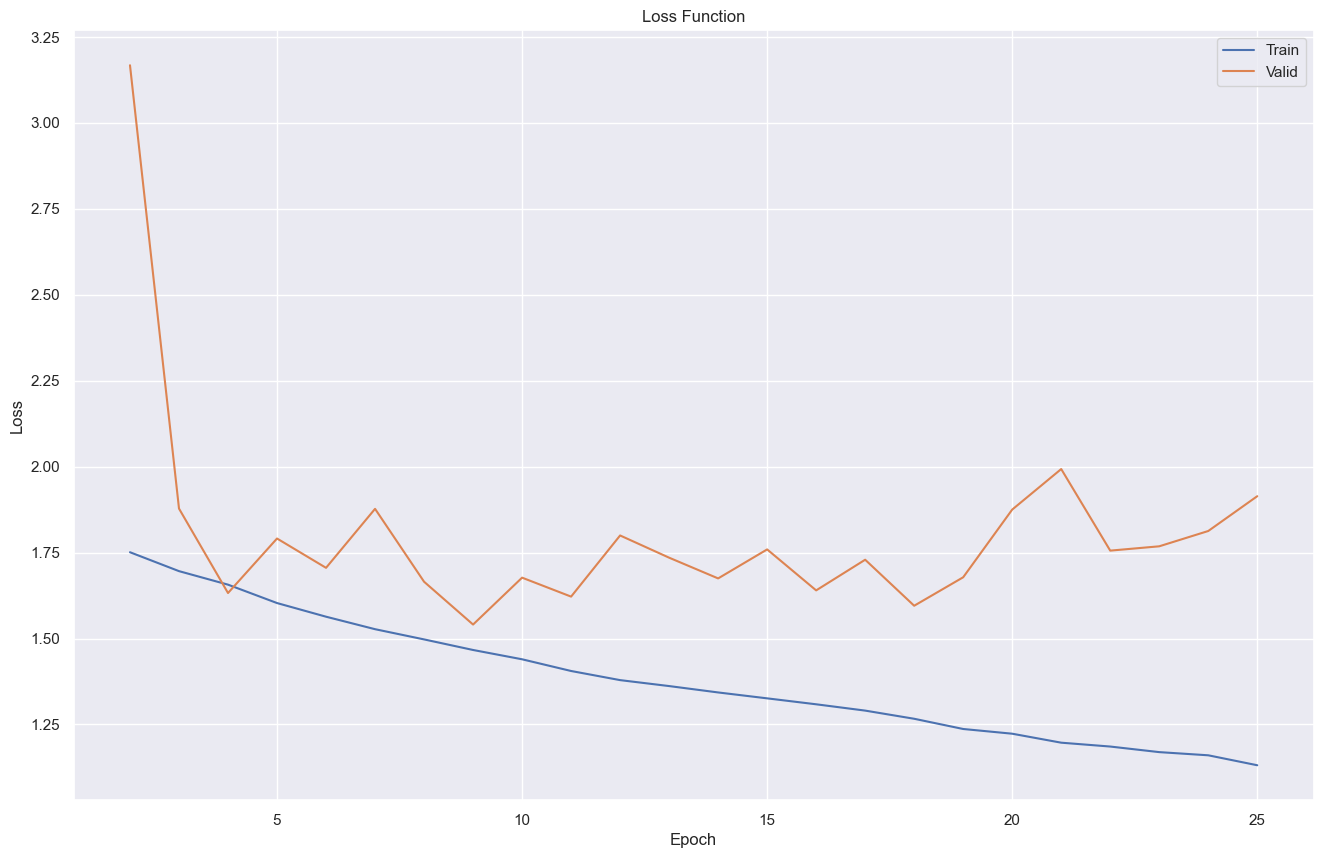

In [29]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report       = report,
	title        = 'Loss Function',
	filename     = os.path.join(OUT_PLOT1, model.__name__),
	limit_bot    = None,
	limit_top    = None,
	start_index  = CONFIG['core/plots']
)

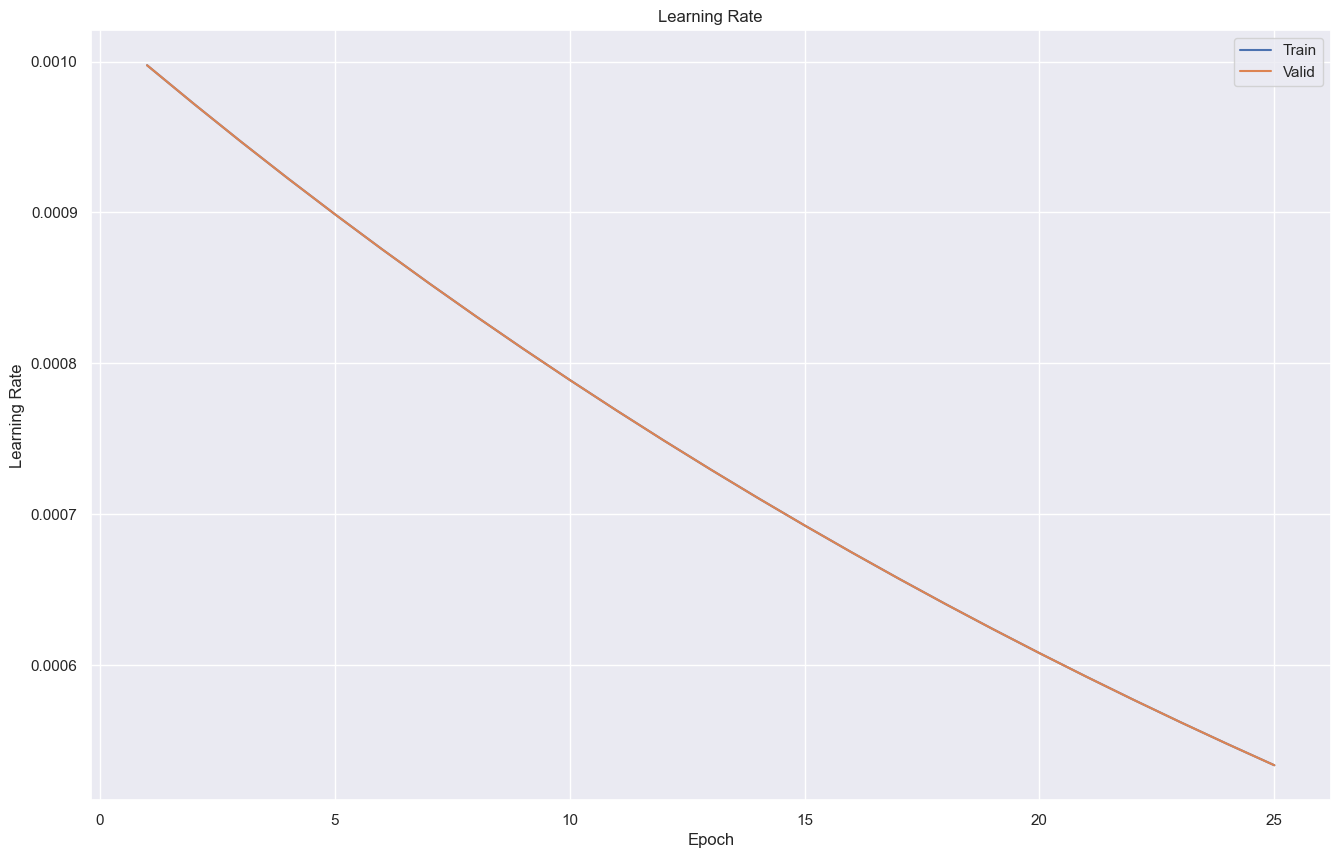

In [30]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report      = report,
	title       = 'Learning Rate',
	filename    = os.path.join(OUT_PLOT1, model.__name__),
	limit_bot   = None,
	limit_top   = None,
	start_index = None
)

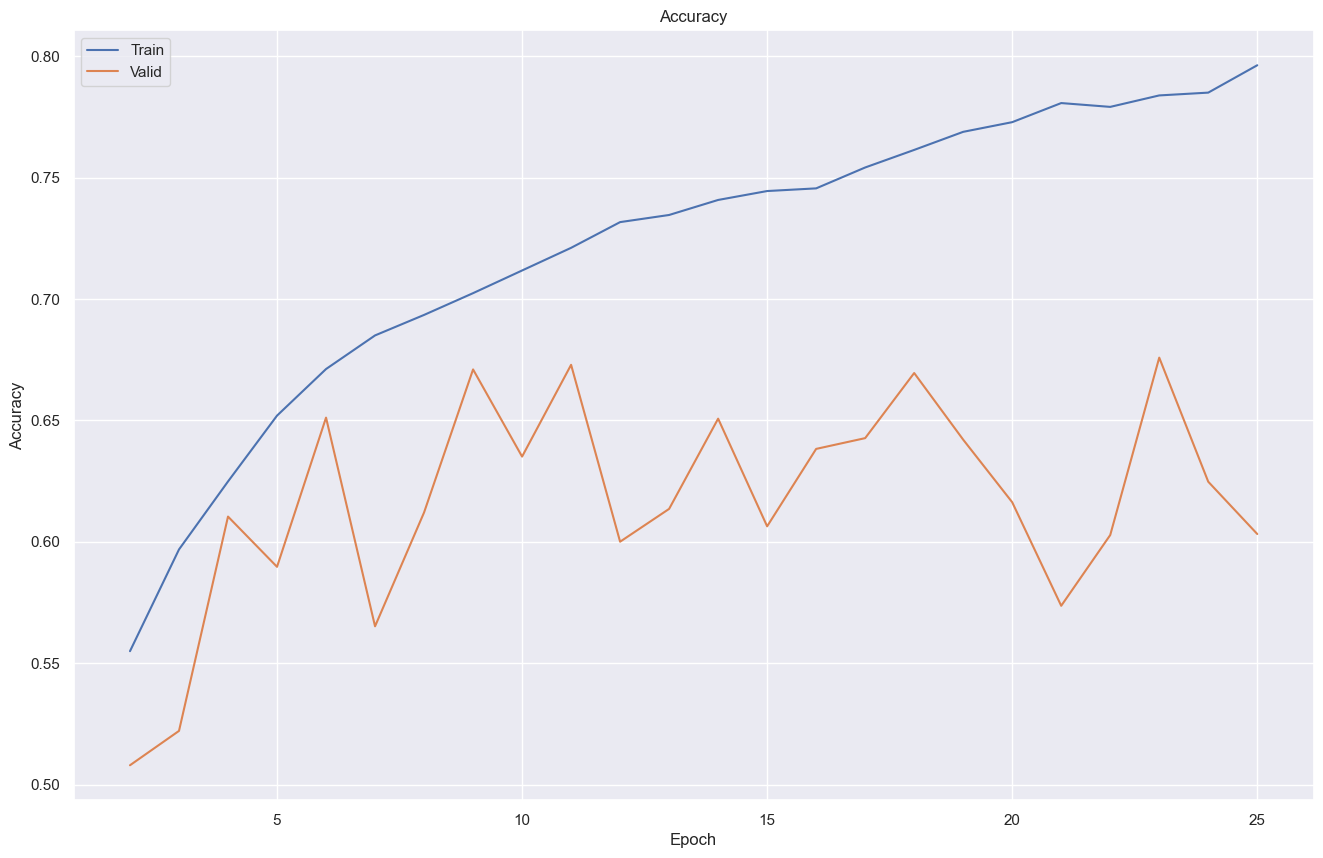

In [31]:
# Display the training and validation accuracy or r2 curves

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_r2(
		report       = report,
		title        = 'R2 Score',
		filename     = os.path.join(OUT_PLOT1, model.__name__),
		limit_bot    = None,
		limit_top    = None,
		start_index  = CONFIG['core/plots']
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.show_accuracy(
		report       = report,
		title        = 'Accuracy',
		filename     = os.path.join(OUT_PLOT1, model.__name__),
		limit_bot    = None,
		limit_top    = None,
		start_index  = CONFIG['core/plots']
	)

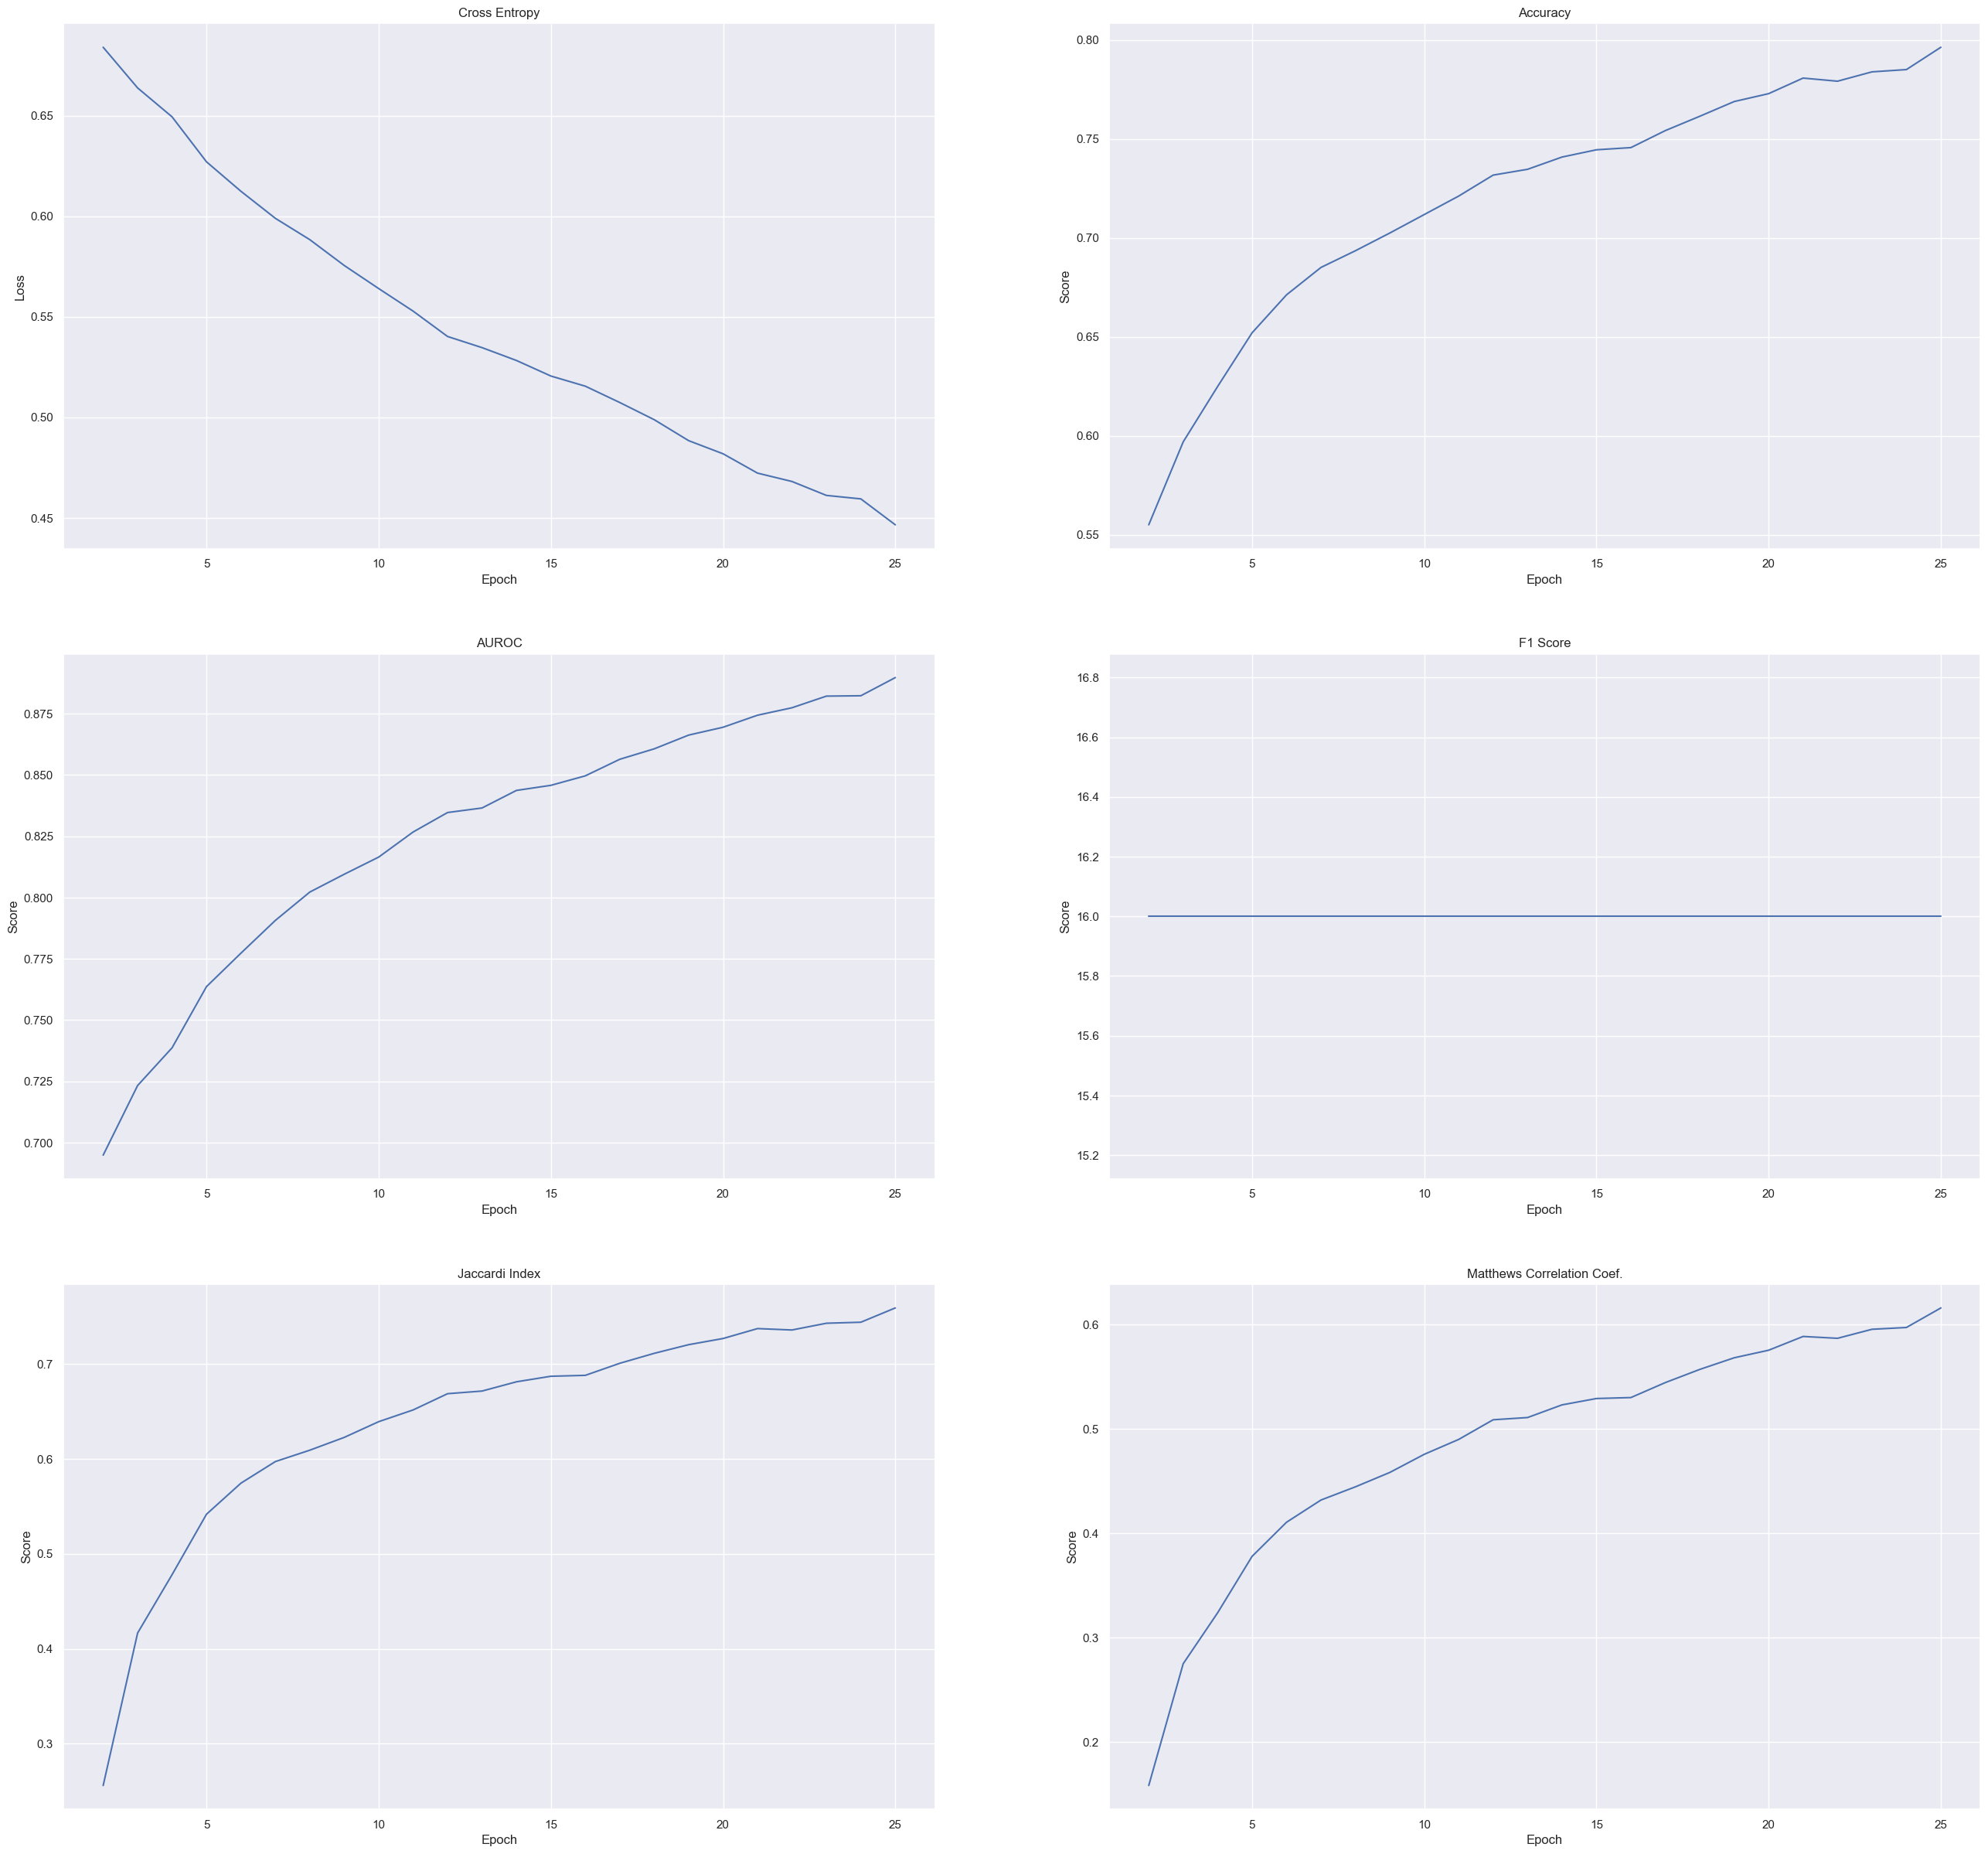

In [32]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'train',
	filename     = os.path.join(OUT_PLOT1, model.__name__ + '-train'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

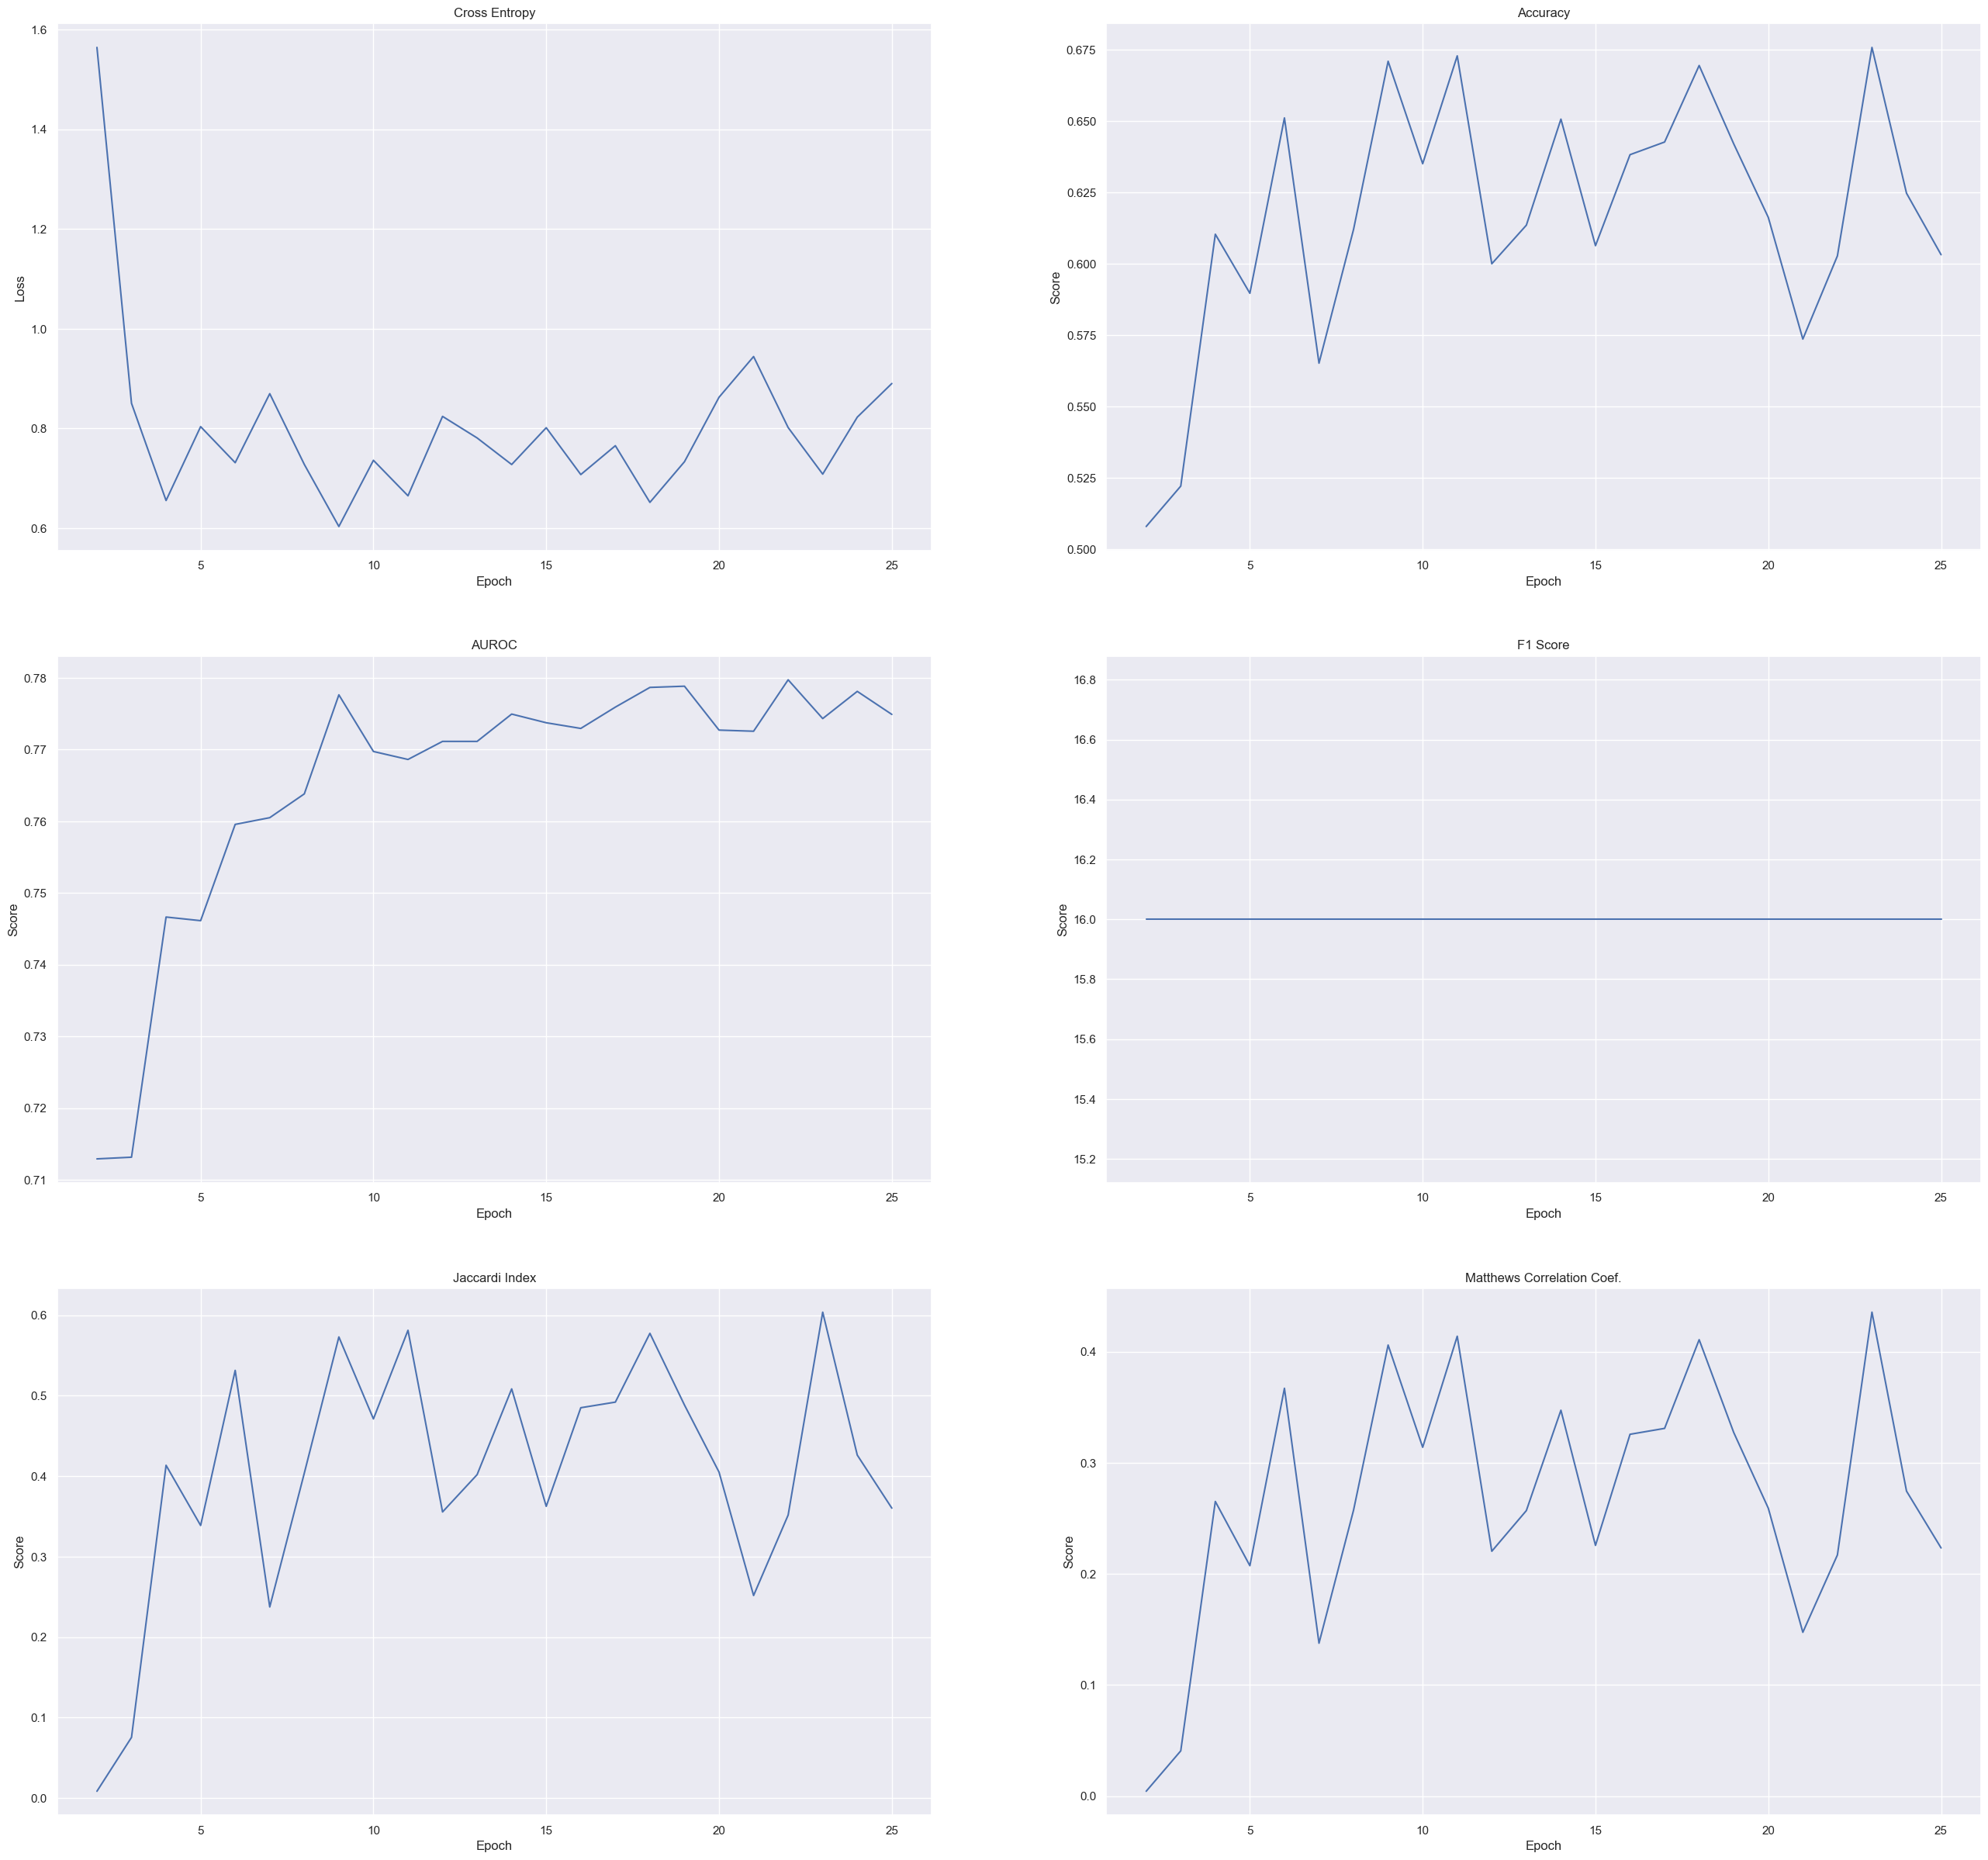

In [33]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'valid',
	filename     = os.path.join(OUT_PLOT1, model.__name__ + '-valid'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

## 3.3 Evaluation

### 3.3.1 Last Model

#### 3.3.1.1 Evaluation

In [34]:
# Load last model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL1, model.__name__ + '-last.pth')
)

final_report['evaluation/last/epoch'] = checkpoint['epoch']
final_report['evaluation/last/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 25
 Loss : 1.91406



<All keys matched successfully>

In [35]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

Mode     : evaluation/last/test
Accuracy :    0.60156
Entropy  :    0.91635
Auroc    :    0.76556
Matthews :    0.27854



In [36]:
# Evaluate the full model on full test

if CONFIG['model/mode'] == 'regression' :
	report_full, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : full_dataloader
		},
		report = final_report,
		mode   = 'evaluation/last/full'
	)

if CONFIG['model/mode'] == 'classification' :
	report_full, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : full_dataloader
		},
		report = final_report,
		mode   = 'evaluation/last/full'
	)

Mode     : evaluation/last/full
Accuracy :    0.51733
Entropy  :    1.02117
Auroc    :    0.88130
Matthews :    0.31571



### 3.3.2 Best Model

#### 3.3.2.1 Evaluation

In [37]:
# Load best model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL1, model.__name__ + '-best.pth')
)

final_report['evaluation/best/epoch'] = checkpoint['epoch']
final_report['evaluation/best/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/best/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/best/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 9
 Loss : 1.54071



<All keys matched successfully>

In [38]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

Mode     : evaluation/best/test
Accuracy :    0.66355
Entropy  :    0.61278
Auroc    :    0.77284
Matthews :    0.35809



In [39]:
# Evaluate the full model on full test

if CONFIG['model/mode'] == 'regression' :
	report_full, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : full_dataloader
		},
		report = final_report,
		mode   = 'evaluation/best/full'
	)

if CONFIG['model/mode'] == 'classification' :
	report_full, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : full_dataloader
		},
		report = final_report,
		mode   = 'evaluation/best/full'
	)

Mode     : evaluation/best/full
Accuracy :    0.62648
Entropy  :    0.65887
Auroc    :    0.82327
Matthews :    0.39721



#### 3.3.2.2 Custom

In [40]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_keep,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_keep,
		n      = 2,
		binary = True
	)

    Key : AT1G14310.1
    True : [ 1.00000]
    Pred : [ 0.23868]
 Entropy : [ 0.71896]
Accuracy : [ 0.56250]

    Key : AT1G74860.1
    True : [ 1.00000]
    Pred : [ 0.20222]
 Entropy : [ 0.54739]
Accuracy : [ 0.73438]



In [41]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_full,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_full,
		n      = 2
	)

    Key : AT1G07780.10
    True : [ 1.00000]
    Pred : [ 0.29067]
 Entropy : [ 0.74836]
Accuracy : [ 0.51562]

    Key : AT5G59340.1
    True : [ 0.00000]
    Pred : [ 0.06058]
 Entropy : [ 0.72877]
Accuracy : [ 0.54688]



#### 3.3.2.3 Visualization

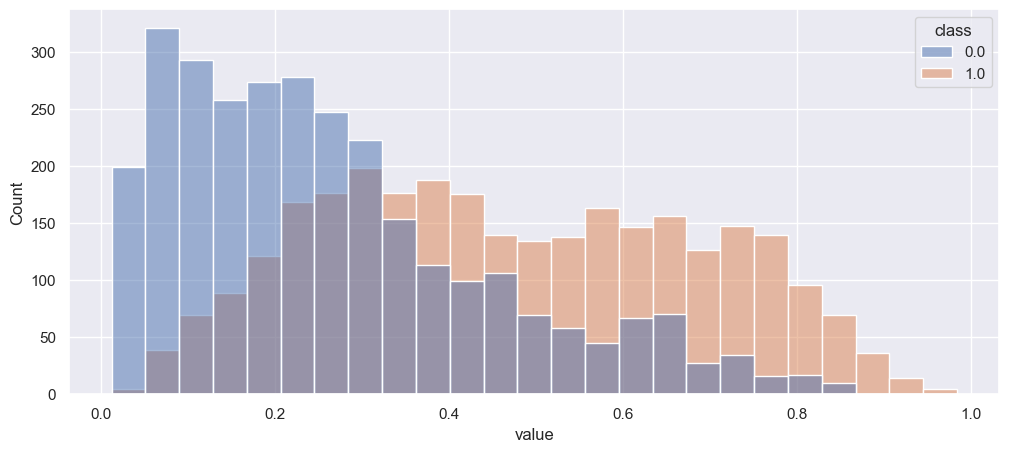

In [42]:
# Plot prediction histplot

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.plot_prediction_histplot(
		report   = report_keep,
		filename = os.path.join(OUT_PLOT1, model.__name__ + '-keep'),
		figsize  = (12, 5)
	)

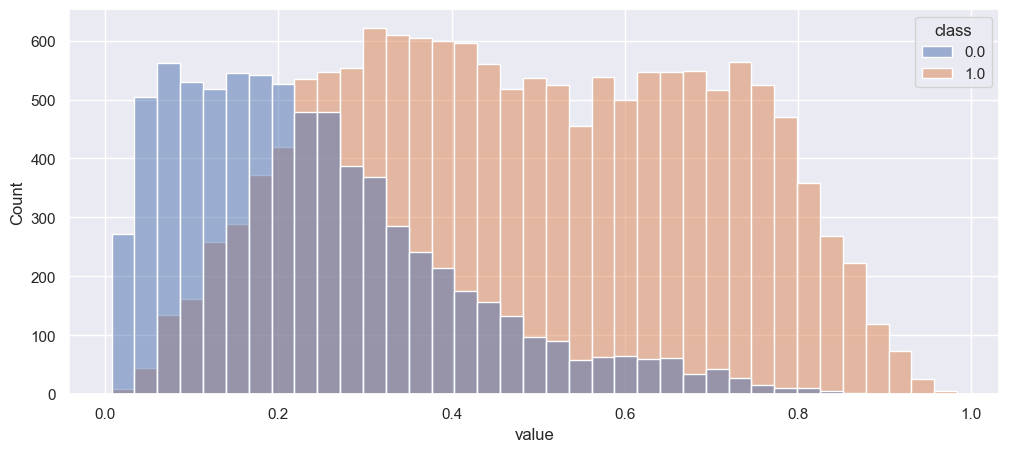

In [43]:
# Plot prediction histplot

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.plot_prediction_histplot(
		report   = report_full,
		filename = os.path.join(OUT_PLOT1, model.__name__ + '-keep'),
		figsize  = (12, 5)
	)

Reshaping matrix from [184, 2] to [92, 2, 2]



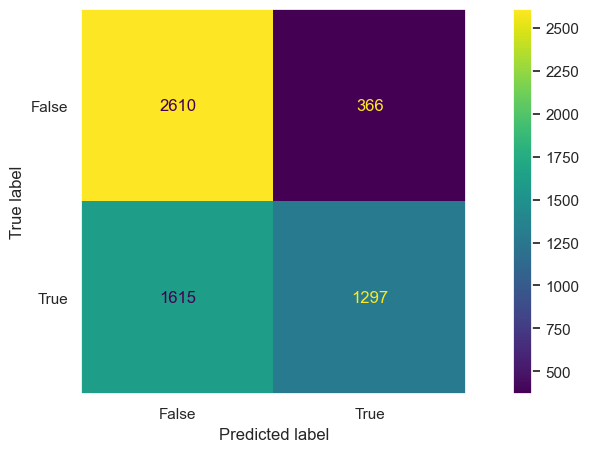

In [44]:
# Plot confusion matrix

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.plot_confusion_matrix(
		report   = report_keep,
		filename = os.path.join(OUT_PLOT1, model.__name__ + '-full'),
		figsize  = (12, 5)
	)

Reshaping matrix from [698, 2] to [349, 2, 2]



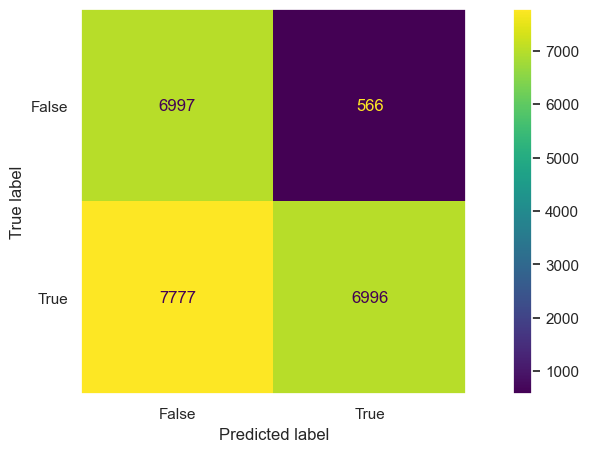

In [45]:
# Plot confusion matrix

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.plot_confusion_matrix(
		report   = report_full,
		filename = os.path.join(OUT_PLOT1, model.__name__ + '-full'),
		figsize  = (12, 5)
	)

In [46]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_keep,
		order    = ['on/off'],
		filename = os.path.join(OUT_PLOT1, model.__name__ + '-keep-best')
	)

In [47]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_full,
		order    = ['on/off'],
		filename = os.path.join(OUT_PLOT1, model.__name__ + '-full-best')
	)

In [48]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_keep,
		order    = ['on/off'],
		filename = os.path.join(OUT_PLOT1, model.__name__ + '-keep-best')
	)

In [49]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_full,
		order    = ['on/off'],
		filename = os.path.join(OUT_PLOT1, model.__name__ + '-full-best')
	)

## 3.4 Save

In [50]:
# Convert reports from numpy array to lists

def ensure_json_validity (item) :
	if   isinstance(item, dict)          : pass
	elif isinstance(item, list)          : return item
	elif isinstance(item, numpy.ndarray) : return item.tolist()
	elif isinstance(item, float)         : return item
	elif isinstance(item, int)           : return item
	elif isinstance(item, str)           : return item
	else                                 : return None

	data = dict()

	for key in item.keys() :
		data[key] = ensure_json_validity(item[key])

	return data

report_keep = ensure_json_validity(report_keep)
report_full = ensure_json_validity(report_full)

In [51]:
# Save results

for key, value in final_report.items() :
	if isinstance(value, numpy.float32) :
		final_report[key] = float(value)

writer.write_json(
	data     = final_report,
	filename = os.path.join(OUT_DATA1, 'report.json')
)

writer.write_json(
	data     = report_keep,
	filename = os.path.join(OUT_DATA1, 'report_keep.json')
)

writer.write_json(
	data     = report_full,
	filename = os.path.join(OUT_DATA1, 'report_full.json')
)

writer.write_json(
	data     = {k : v for k, v in CONFIG.items() if k != 'core/device'},
	filename = os.path.join(OUT_DATA1, 'config.json')
)

# 4. Regression

In [52]:
# Update to correct mode

CONFIG['model/mode']              = 'regression'
CONFIG['model/features']          = True
CONFIG['dataset/split/generator'] = 'group'
CONFIG['criterion/name']          = 'corrected-mse'

final_report = dict()

## 4.1 Dataloader

### 4.1.1 Convert

In [53]:
# Print examples

genes = numpy.array(report_full['eval']['keys'],  dtype = str          ).flatten()
ypred = numpy.array(report_full['eval']['ypred'], dtype = numpy.float64).flatten()
ytrue = numpy.array(report_full['eval']['ytrue'], dtype = numpy.float64).flatten()

for i in range(5) :
	print('{} : pred = {:.05f} : true = {:0.1f}'.format(genes[i], ypred[i], ytrue[i]))

print()

AT1G07780.10 : pred = 0.29067 : true = 1.0
AT5G59340.1 : pred = 0.06058 : true = 0.0
AT2G36120.1 : pred = 0.67810 : true = 1.0
AT2G19350.1 : pred = 0.37601 : true = 1.0
AT3G48200.1 : pred = 0.35919 : true = 1.0



### 4.1.2 Select

In [54]:
# Select only expressed transcripts

transcripts = genes[ypred > 0.5]

x = len(transcripts)
y = len(genes)

print('Selected {:5,d} [{:.2f} %] of all transcripts'.format(x, 100 * x / y))
print()

sequence = {k : v for k, v in sequence_merge.items() if k in transcripts}
features = {k : v for k, v in features_merge.items() if k in transcripts}

Selected 7,562 [33.86 %] of all transcripts



In [55]:
# Get targets

target_name = '{}-{}'.format(
	CONFIG['model/output/target'],
	CONFIG['model/output/type']
)

if CONFIG['model/output/explode'] :
	if CONFIG['model/output/filter'] is None : target_name = '{}-{}'.format(target_name, 'explode')
	else                                     : target_name = '{}-{}'.format(target_name, CONFIG['model/output/filter'])

print('Target Name    : {}'.format(target_name))
print('Output Target  : {}'.format(CONFIG['model/output/target']))
print('Output Type    : {}'.format(CONFIG['model/output/type']))
print('Output Explode : {}'.format(CONFIG['model/output/explode']))
print('Output Filter  : {}'.format(CONFIG['model/output/filter']))
print()

data_keep = loader.load_pickle(filename = os.path.join(RES_NBP05, 'mapping-grouped-keep.pkl'))
data_drop = loader.load_pickle(filename = os.path.join(RES_NBP05, 'mapping-grouped-drop.pkl'))

targets_keep = data_keep[target_name]
targets_keep = targets_keep.set_index('ID')
targets_keep = targets_keep.to_dict(orient = 'index')

targets_drop = data_drop[target_name]
targets_drop = targets_drop.set_index('ID')
targets_drop = targets_drop.to_dict(orient = 'index')

targets =      {k : v['TPM_Value'] for k, v in targets_keep.items()}
targets.update({k : v['TPM_Value'] for k, v in targets_drop.items()})

targets = {k : v for k, v in targets.items() if k in transcripts}

print('Sequence : {:,d}'.format(len(sequence)))
print('Features : {:,d}'.format(len(features)))
print('Targets  : {:,d}'.format(len(targets)))
print()

Target Name    : global-mean
Output Target  : global
Output Type    : mean
Output Explode : False
Output Filter  : None

Sequence : 7,562
Features : 7,562
Targets  : 7,562



### 4.1.3 Normal

In [56]:
# Create dataset

CONFIG['model/output/size']    = 1
CONFIG['model/output/heads']   = None
CONFIG['model/input/features'] = len(list(features_chunk[0].values())[0])

start = CONFIG['dataset/sequence/start']
end   = CONFIG['dataset/sequence/end']

dataset = cnn_switch.to_dataset(
	sequence = sequence,
	features = features,
	targets  = targets,
	config   = CONFIG,
)[0]

CONFIG['model/fc3/features'] = CONFIG['model/output/size']
CONFIG['model/fc3/heads']    = CONFIG['model/output/heads']

print('Input Features : {}'.format(CONFIG['model/input/features']))
print('Output Size    : {}'.format(CONFIG['model/output/size']))
print('Output Heads   : {}'.format(CONFIG['model/output/heads']))
print()

Input Features : 72
Output Size    : 1
Output Heads   : None



In [57]:
# Create dataloader

dataloaders = cnn_switch.to_dataloader(
	dataset_all =  dataset,
	dataset_mix = [dataset],
	config      = CONFIG
)

train_dataloader = dataloaders[1][0][0]
valid_dataloader = dataloaders[1][1][0]
test_dataloader  = dataloaders[1][2][0]
full_dataloader  = dataloaders[0]

In [58]:
# Display train dataloader

dataset_utils.show_dataloader(
	dataloader = train_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [59]:
# Display valid dataloader

dataset_utils.show_dataloader(
	dataloader = valid_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [60]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [61]:
# Display full dataloader

dataset_utils.show_dataloader(
	dataloader = full_dataloader,
	verbose    = CONFIG['core/verbose']
)

## 4.2 Model

### 4.2.1 Structure

In [62]:
# Create and display the model structure

if CONFIG['model/name'] == 'zrimec' :
	if CONFIG['model/mode'] == 'regression'     : model = Zrimec2020r(params = CONFIG)
	if CONFIG['model/mode'] == 'classification' : model = Zrimec2020c(params = CONFIG, binary = False)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

if CONFIG['model/name'] == 'washburn' :
	if CONFIG['model/mode'] == 'regression'     : model = Washburn2019r(params = CONFIG)
	if CONFIG['model/mode'] == 'classification' : model = Washburn2019c(params = CONFIG, binary = False)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_channels = CONFIG['model/input/channels'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

print()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [64, 4, 2150]             [64, 1]                   --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 512]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 256, 2150]           5,376
│    └─LeakyReLU: 2-2                    [64, 256, 2150]           [64, 256, 2150]           --
│    └─BatchNorm1d: 2-3                  [64, 256, 2150]           [64, 256, 2150]           512
│    └─Dropout: 2-4                      [64, 256, 2150]           [64, 256, 2150]           --
│    └─MaxPool1d: 2-5                    [64, 256, 2150]           [64, 256, 717]            --
│    └─Conv1d: 2-6                       [64, 256, 717]            [64, 64, 717]             180,288
│    └─LeakyReLU: 2-7                    [64, 64, 717]             [64, 64, 717]             --
│    └─BatchNorm1d: 2-8   

In [63]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

### 4.2.2 Metrics

In [64]:
# Define metrics

if CONFIG['model/mode'] == 'regression' :
	METRICS = {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'smae'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'smae'),
		'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape',  output_size = CONFIG['model/output/size']),
		'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape', output_size = CONFIG['model/output/size']),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2',    output_size = CONFIG['model/output/size']),
	}

if CONFIG['model/mode'] == 'classification' :
	METRICS = {
		'entropy'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy',  task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'auroc'     : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'auroc',     task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'confusion' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'confusion', task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'f1'        : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'f1',        task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'jaccardi'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'jaccardi',  task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'matthews'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'matthews',  task = 'multiclass', n_classes = CONFIG['model/output/size'])
	}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

### 4.2.3 Parameters

In [65]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG | {
		'criterion/threshold' : 0.15
	},
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL2, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL2, f'{model.__name__}-last.pth'),
	'savetime'  : os.path.join(OUT_MODEL2, f'{model.__name__}-time.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader
}

### 4.2.4 Train

In [66]:
# Train and validate the model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.train_regressor(
		model  = model,
		params = model_params
	)

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.train_classifier(
		model  = model,
		params = model_params
	)

### 4.2.5 Visualization

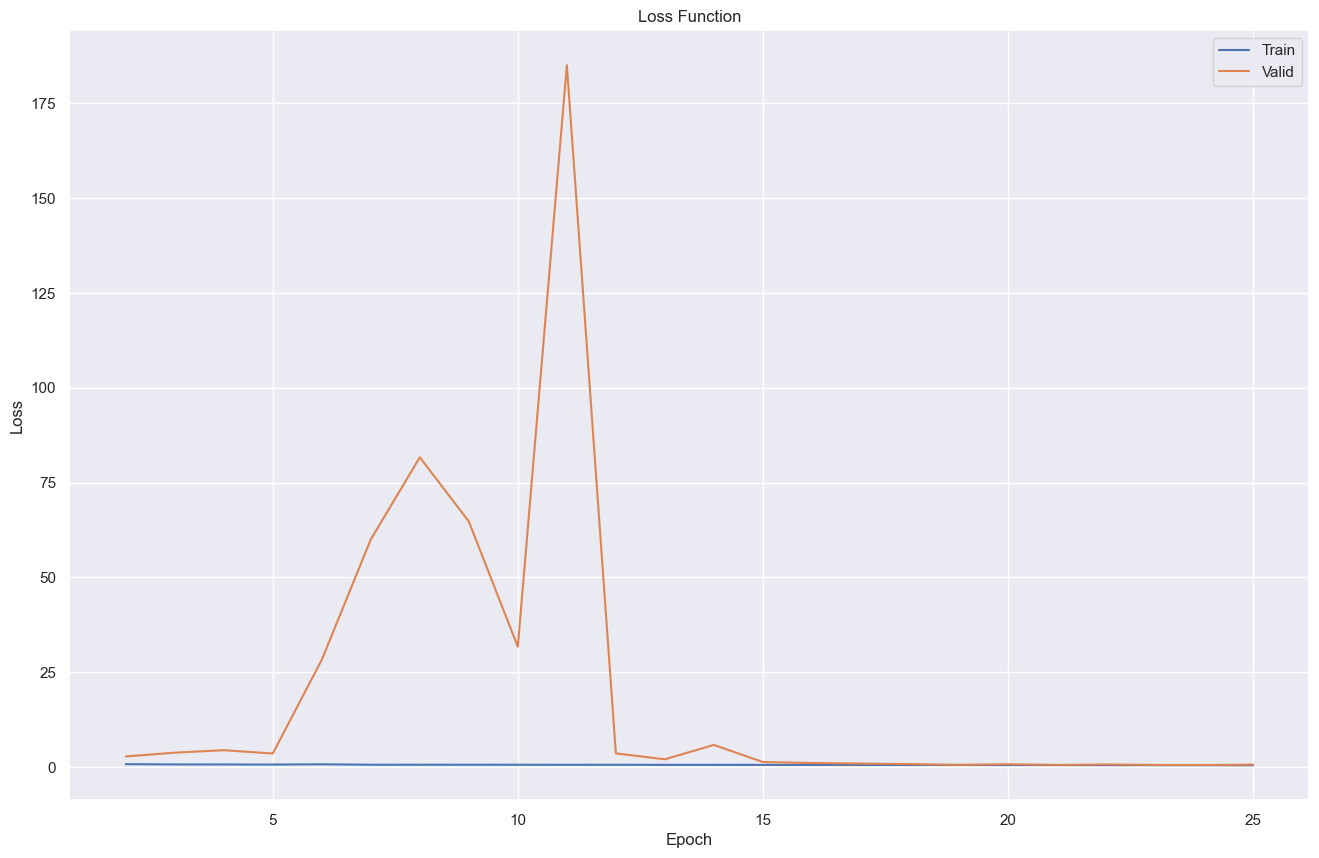

In [67]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report       = report,
	title        = 'Loss Function',
	filename     = os.path.join(OUT_PLOT2, model.__name__),
	limit_bot    = None,
	limit_top    = None,
	start_index  = CONFIG['core/plots']
)

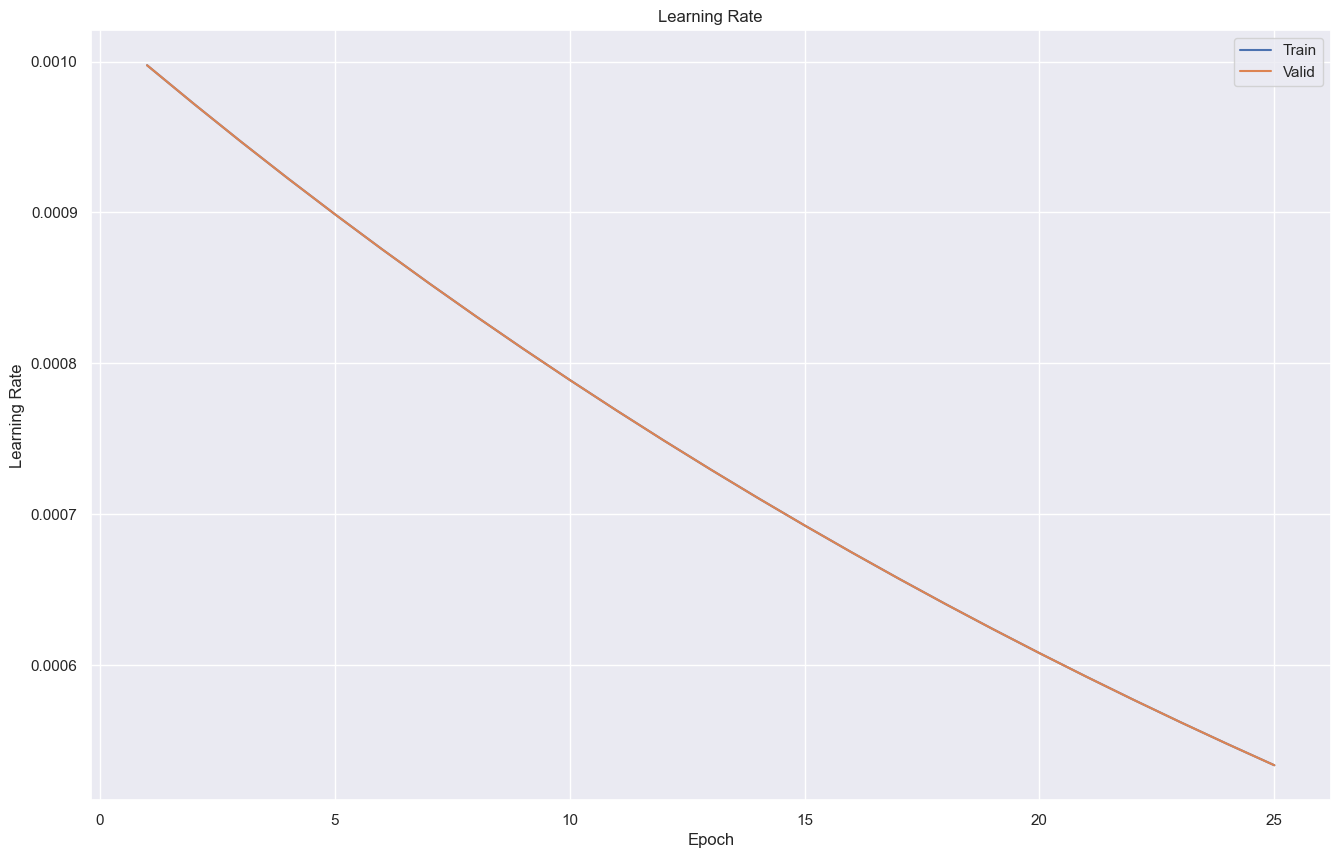

In [68]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report      = report,
	title       = 'Learning Rate',
	filename    = os.path.join(OUT_PLOT2, model.__name__),
	limit_bot   = None,
	limit_top   = None,
	start_index = None
)

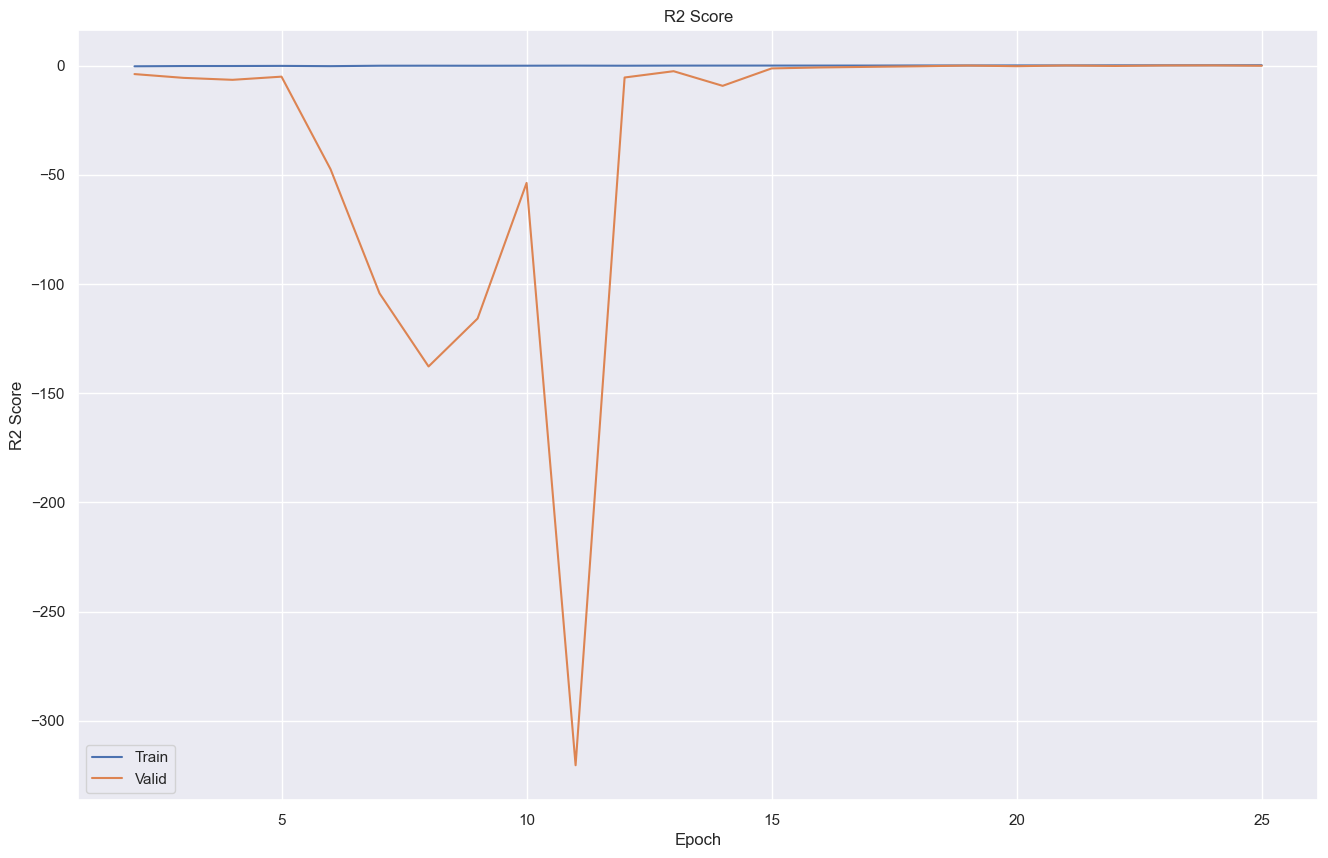

In [69]:
# Display the training and validation accuracy or r2 curves

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_r2(
		report       = report,
		title        = 'R2 Score',
		filename     = os.path.join(OUT_PLOT2, model.__name__),
		limit_bot    = None,
		limit_top    = None,
		start_index  = CONFIG['core/plots']
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.show_accuracy(
		report       = report,
		title        = 'Accuracy',
		filename     = os.path.join(OUT_PLOT2, model.__name__),
		limit_bot    = None,
		limit_top    = None,
		start_index  = CONFIG['core/plots']
	)

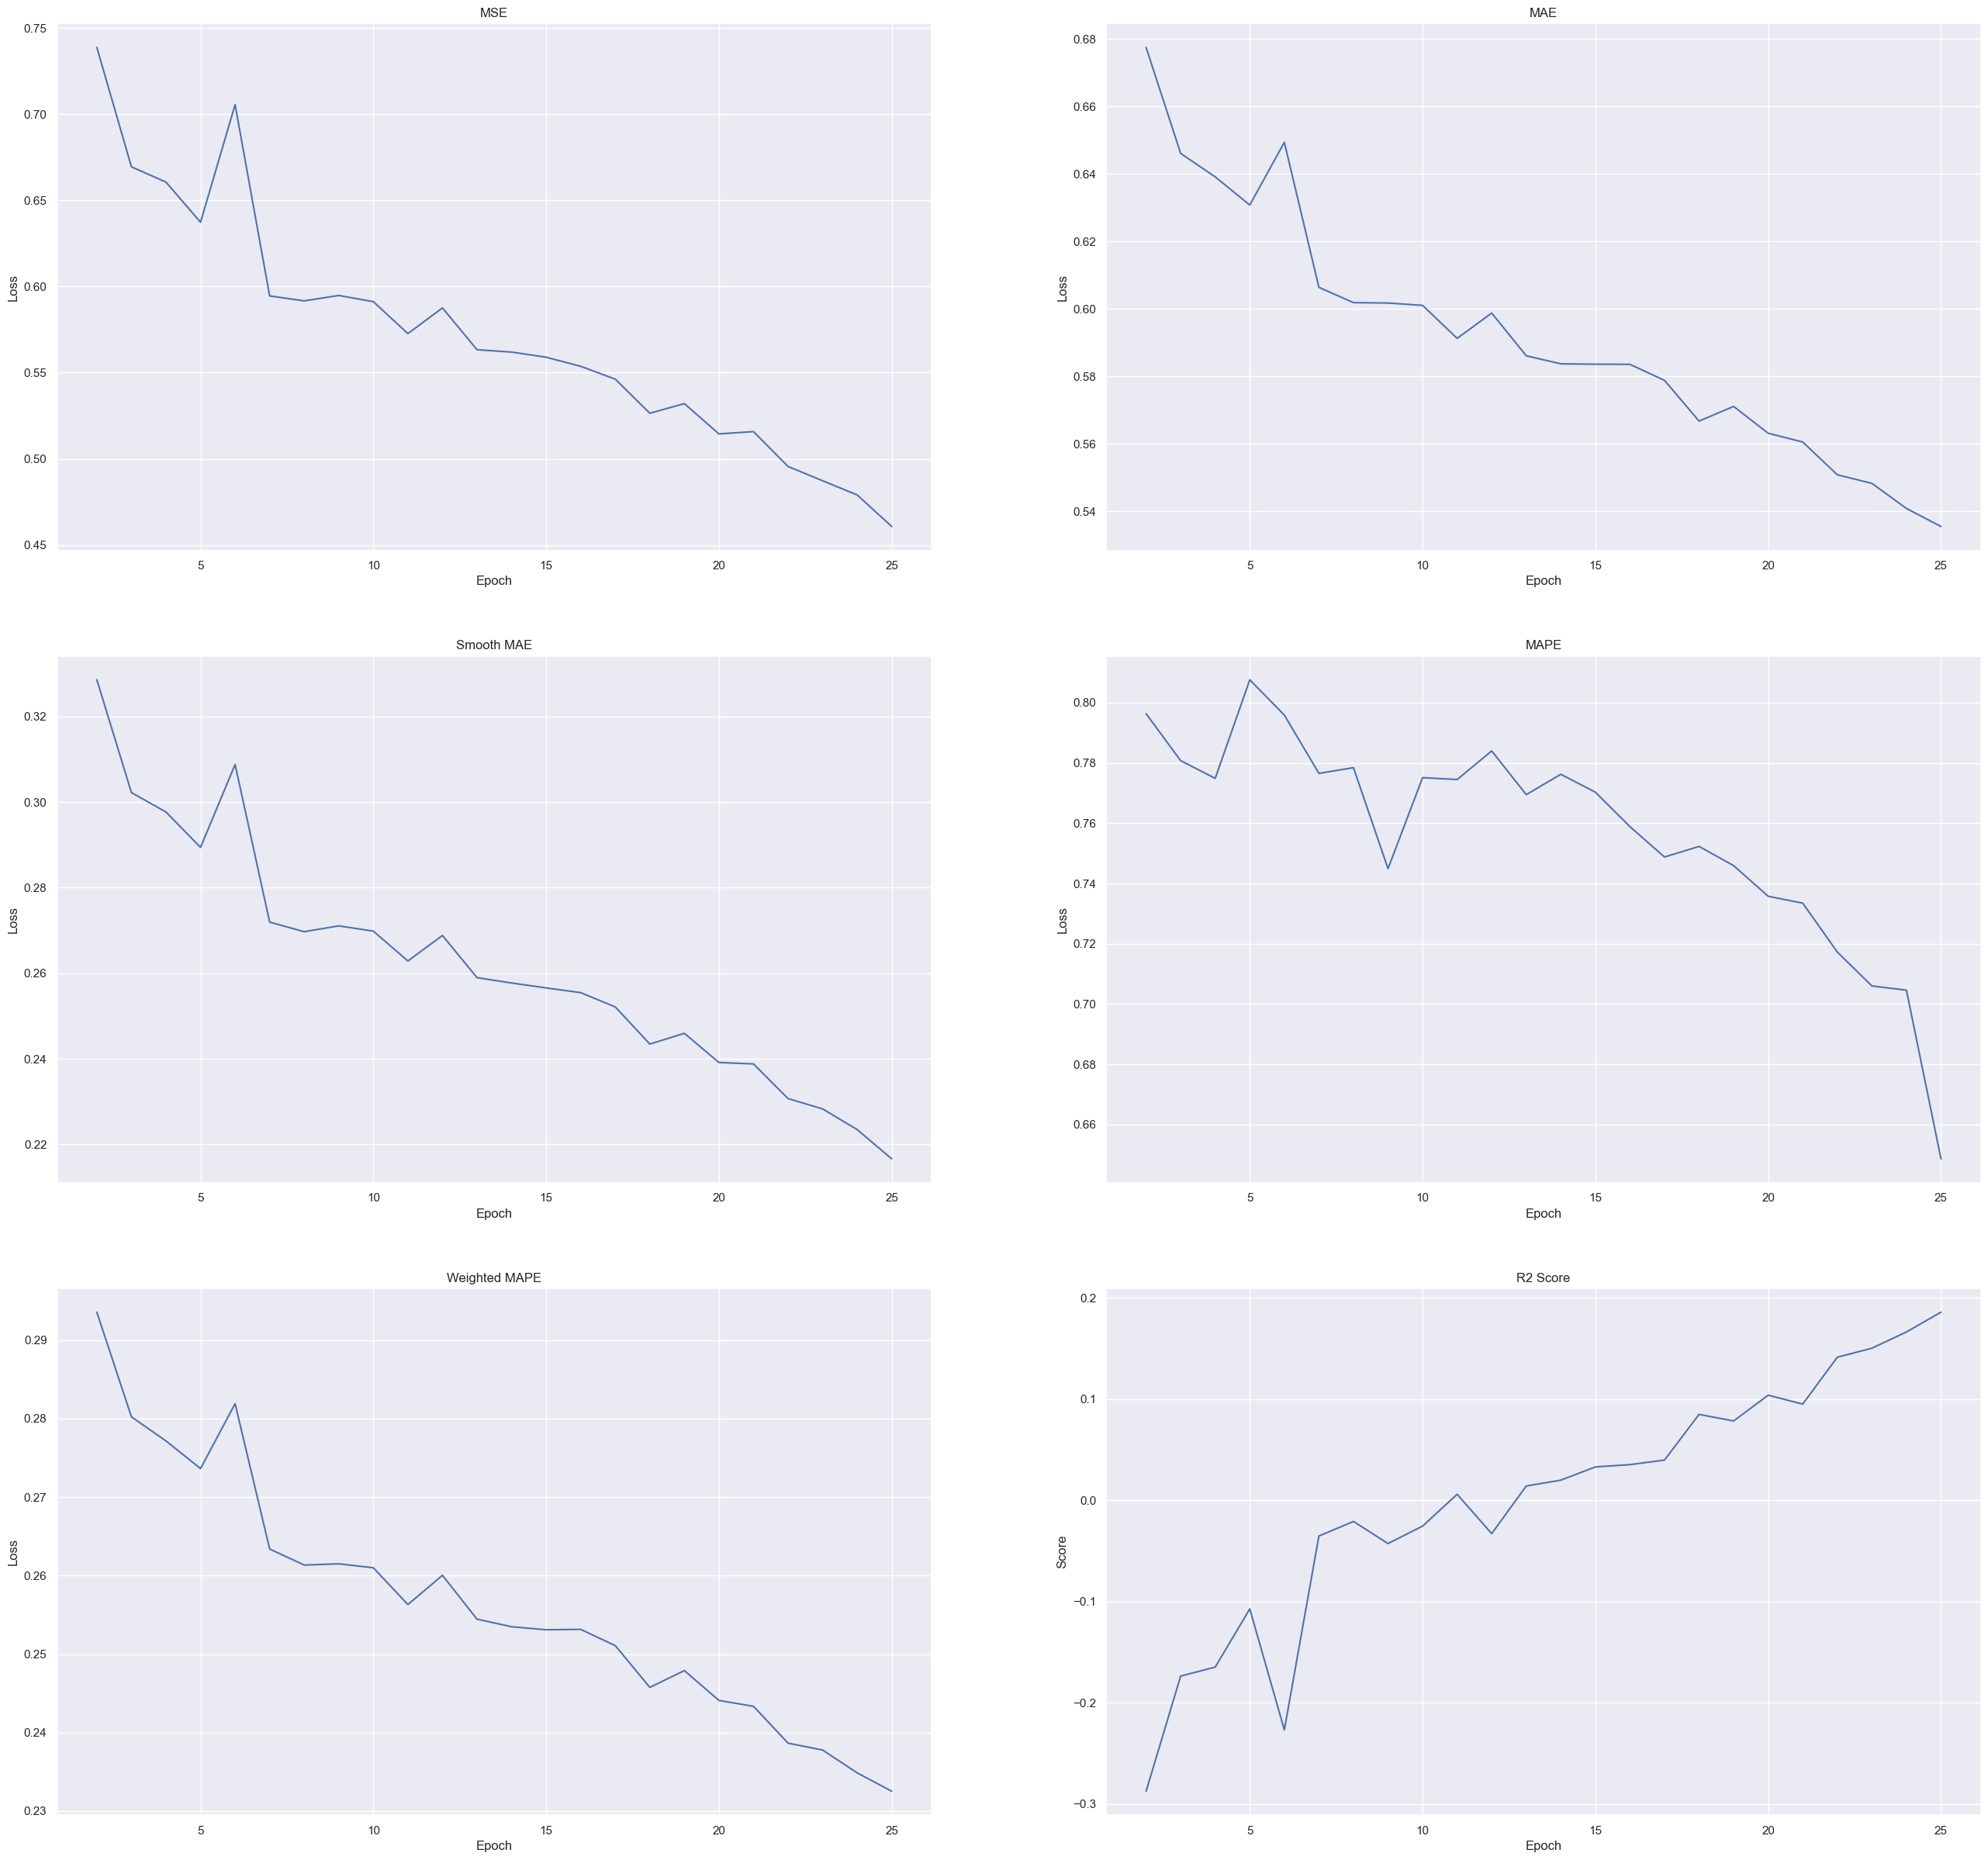

In [70]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'train',
	filename     = os.path.join(OUT_PLOT2, model.__name__ + '-train'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

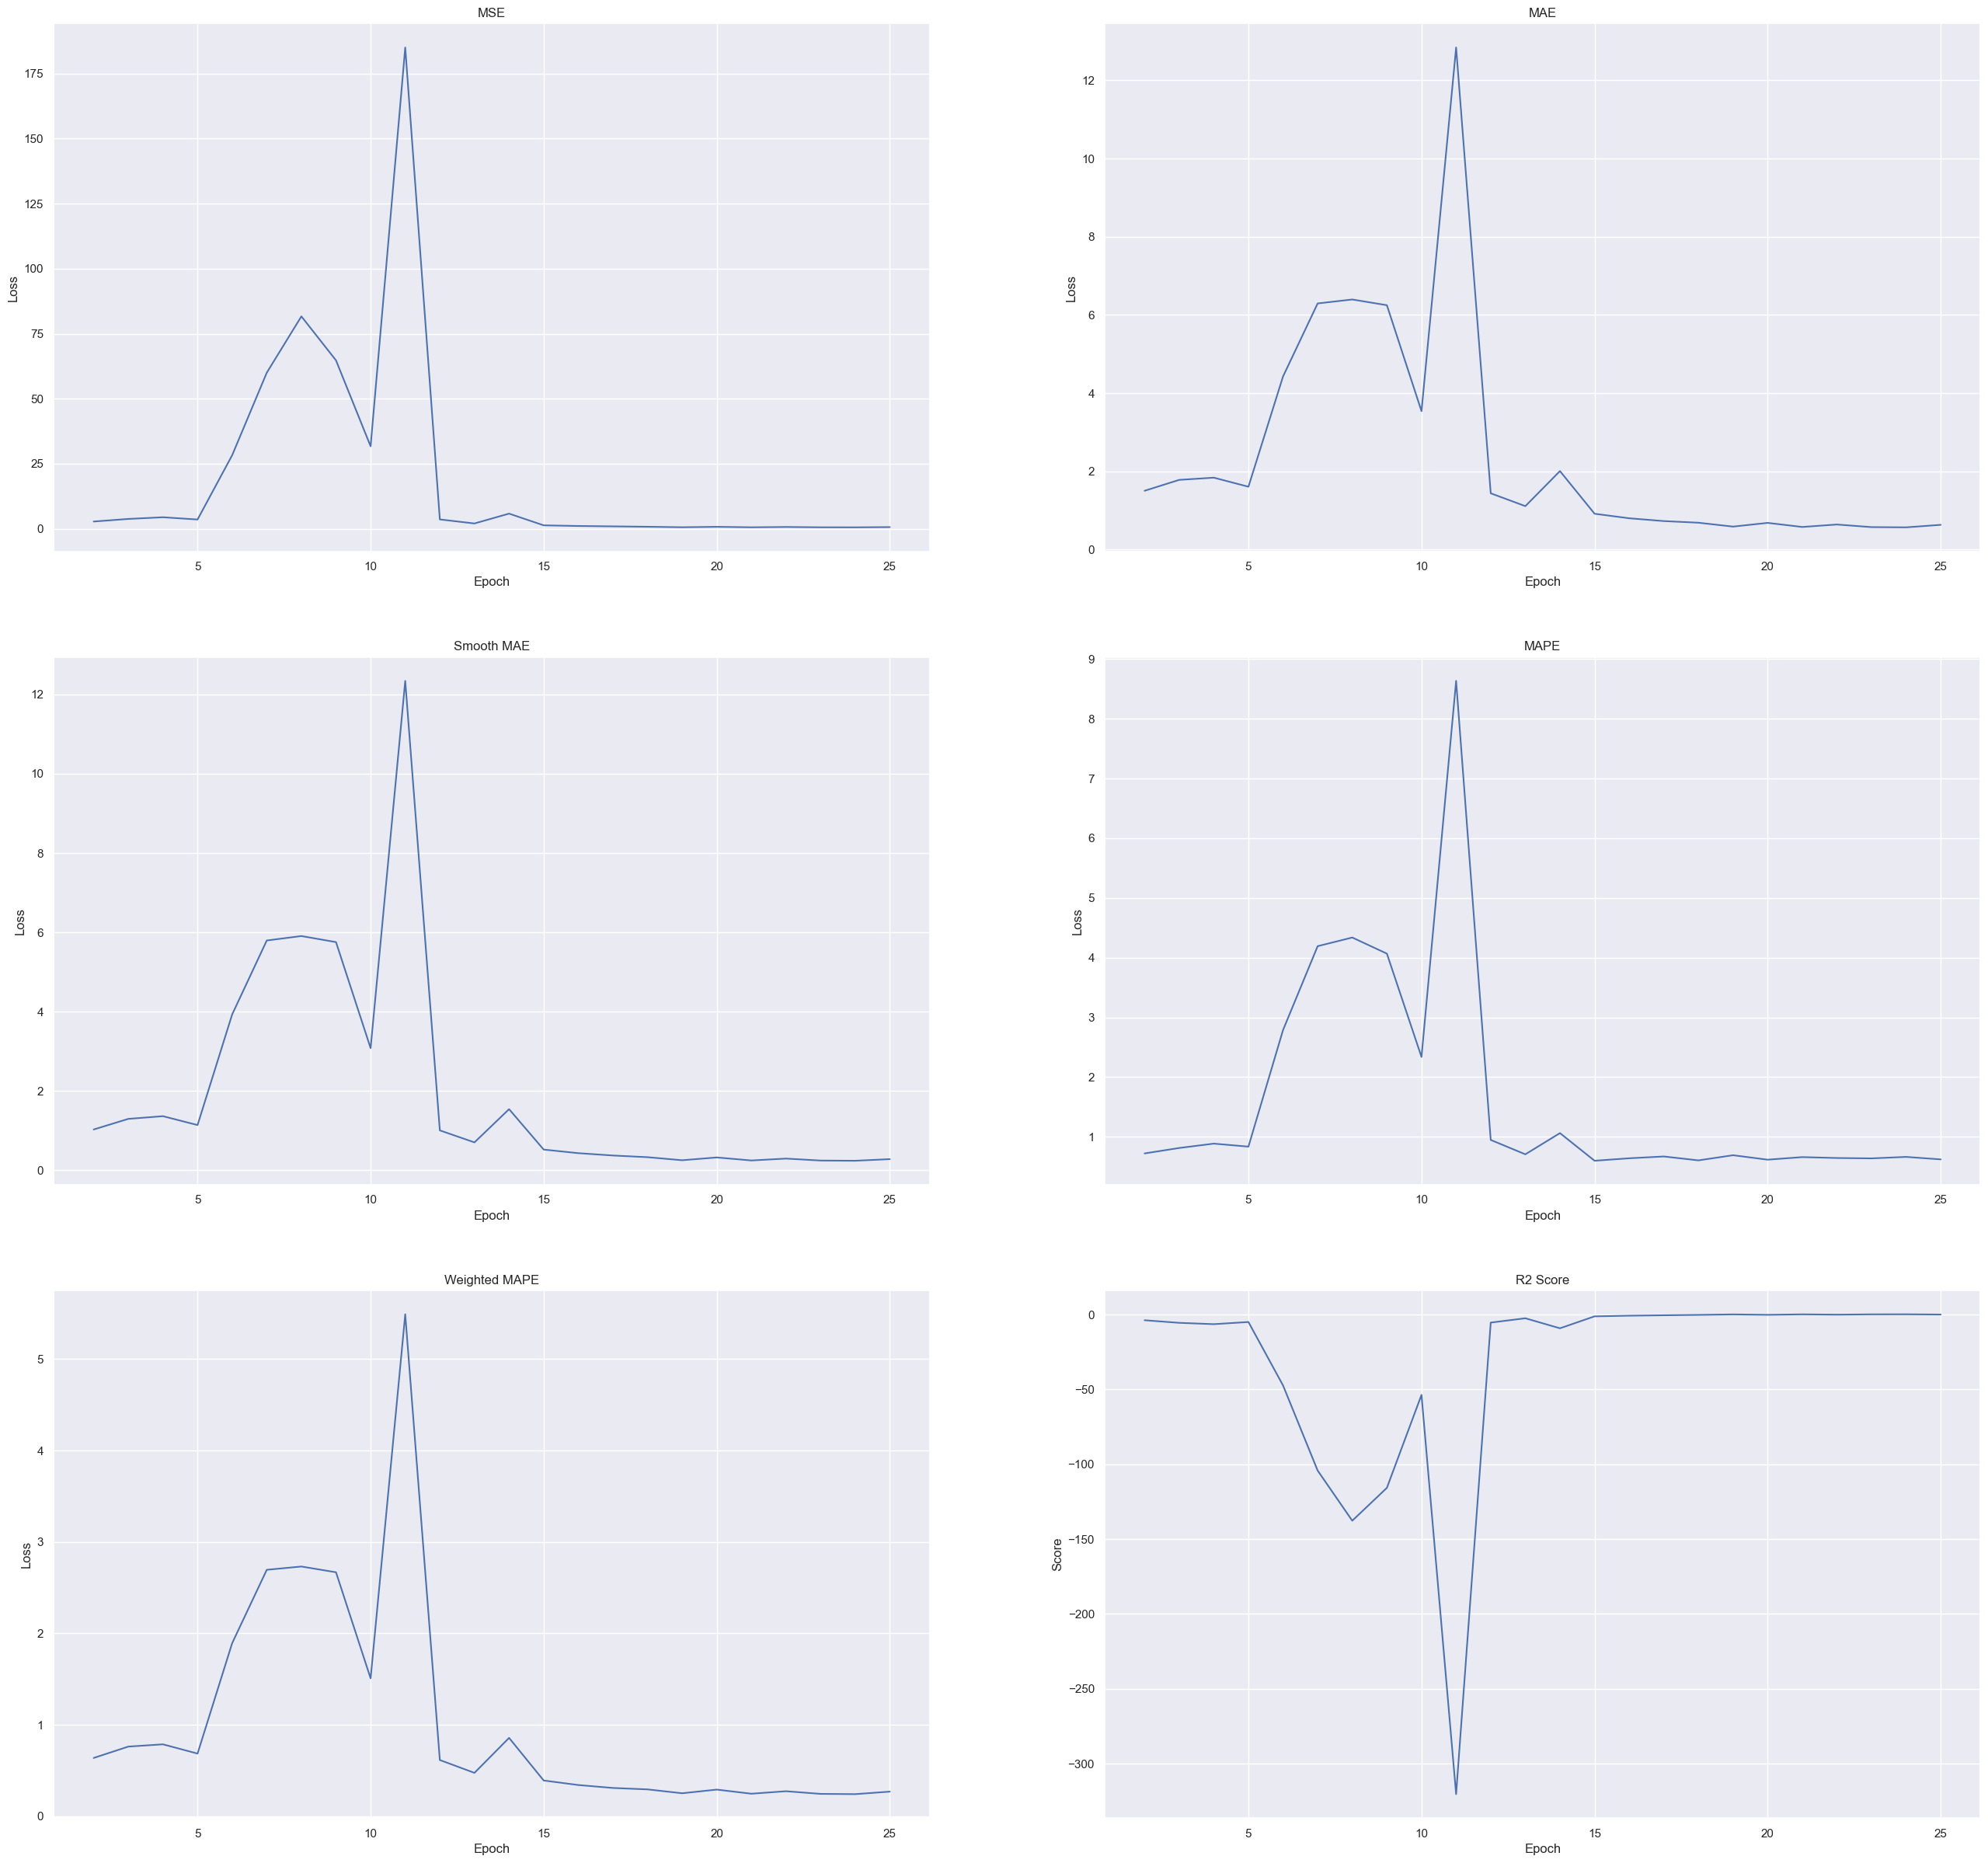

In [71]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'valid',
	filename     = os.path.join(OUT_PLOT2, model.__name__ + '-valid'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

## 4.3 Evaluation

### 4.3.1 Last Model

#### 4.3.1.1 Evaluation

In [72]:
# Load last model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL2, model.__name__ + '-last.pth')
)

final_report['evaluation/last/epoch'] = checkpoint['epoch']
final_report['evaluation/last/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 25
 Loss : 0.60105



<All keys matched successfully>

In [73]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

Mode   : evaluation/last/test
R2     :   -0.06110
MAE    :    0.62386
MSE    :    0.60718
MAPE   :    1.04493
WMAPE  :    0.26924



In [74]:
# Evaluate the full model on full test

if CONFIG['model/mode'] == 'regression' :
	report_full, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : full_dataloader
		},
		report = final_report,
		mode   = 'evaluation/last/full'
	)

if CONFIG['model/mode'] == 'classification' :
	report_full, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : full_dataloader
		},
		report = final_report,
		mode   = 'evaluation/last/full'
	)

Mode   : evaluation/last/full
R2     :    0.14443
MAE    :    0.55578
MSE    :    0.48744
MAPE   :    0.67607
WMAPE  :    0.24005



### 4.3.2 Best Model

#### 4.3.2.1 Evaluation

In [75]:
# Load best model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL2, model.__name__ + '-best.pth')
)

final_report['evaluation/best/epoch'] = checkpoint['epoch']
final_report['evaluation/best/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/best/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/best/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 24
 Loss : 0.50879



<All keys matched successfully>

In [76]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

Mode   : evaluation/best/test
R2     :    0.12184
MAE    :    0.56672
MSE    :    0.51022
MAPE   :    1.02753
WMAPE  :    0.24391



In [77]:
# Evaluate the full model on drop test

if CONFIG['model/mode'] == 'regression' :
	report_full, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : full_dataloader
		},
		report = final_report,
		mode   = 'evaluation/best/full'
	)

if CONFIG['model/mode'] == 'classification' :
	report_full, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : full_dataloader
		},
		report = final_report,
		mode   = 'evaluation/best/full'
	)

Mode   : evaluation/best/full
R2     :    0.24735
MAE    :    0.51433
MSE    :    0.43463
MAPE   :    0.74539
WMAPE  :    0.22253



#### 4.3.2.2 Custom

In [78]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_keep,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_keep,
		n      = 2
	)

 Key : AT2G39730.2
True : [ 3.99660]
Pred : [ 2.86253]
 MAE : [ 1.13407]
 MSE : [ 1.28612]
  R2 : [ 0.21801]

 Key : AT4G05330.1
True : [ 1.35861]
Pred : [ 2.46801]
 MAE : [ 1.10939]
 MSE : [ 1.23075]
  R2 : [ 0.09806]



In [79]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_full,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_full,
		n      = 2
	)

 Key : AT3G03380.1
True : [ 2.56386]
Pred : [ 2.56385]
 MAE : [ 0.00001]
 MSE : [ 0.00000]
  R2 : [ 0.31579]

 Key : AT1G02410.1
True : [ 2.44253]
Pred : [ 2.12311]
 MAE : [ 0.31942]
 MSE : [ 0.10203]
  R2 : [ 0.33836]



#### 4.3.2.3 Visualization

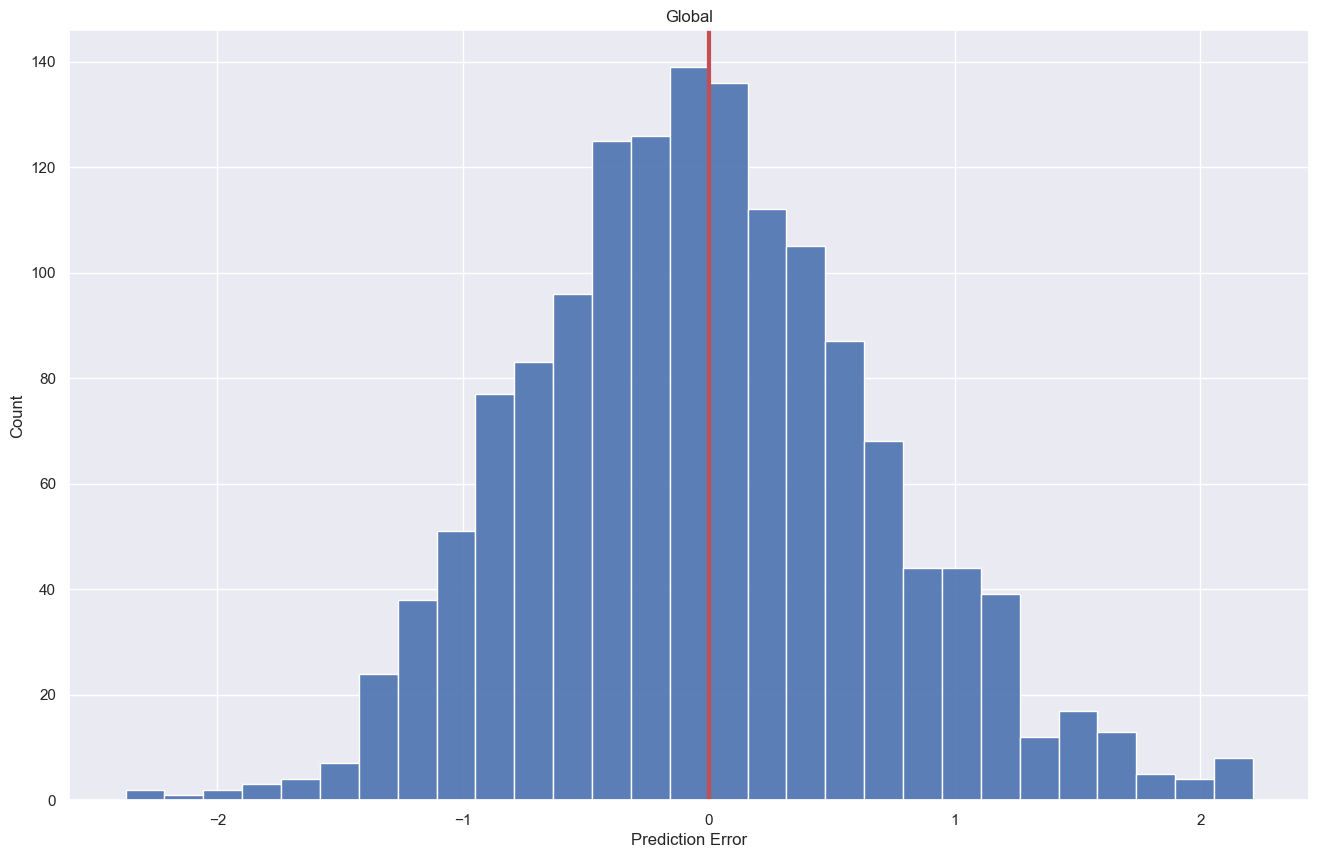

In [80]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_keep,
		order    = target_order,
		filename = os.path.join(OUT_PLOT2, model.__name__ + '-keep-best')
	)

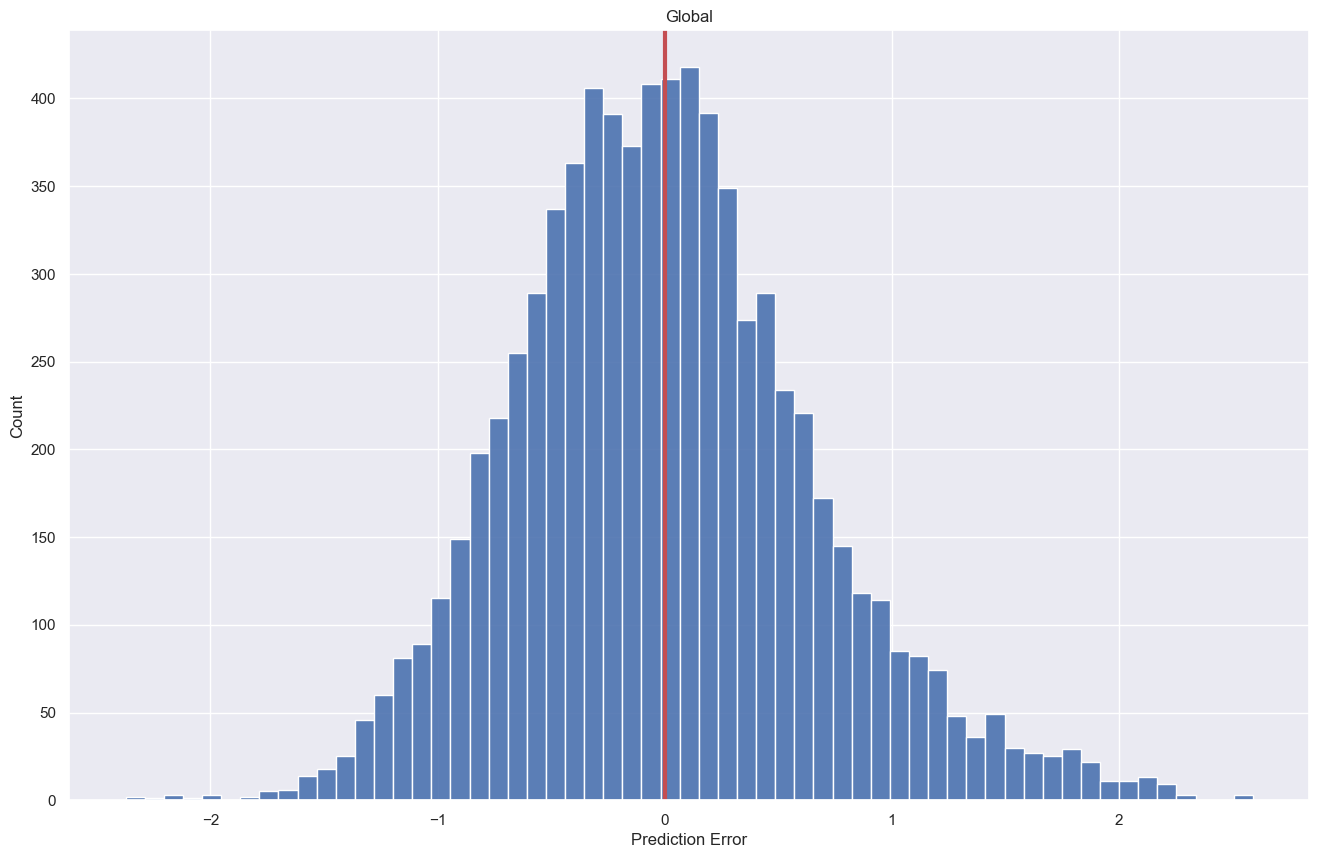

In [81]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_full,
		order    = target_order,
		filename = os.path.join(OUT_PLOT2, model.__name__ + '-full-best')
	)

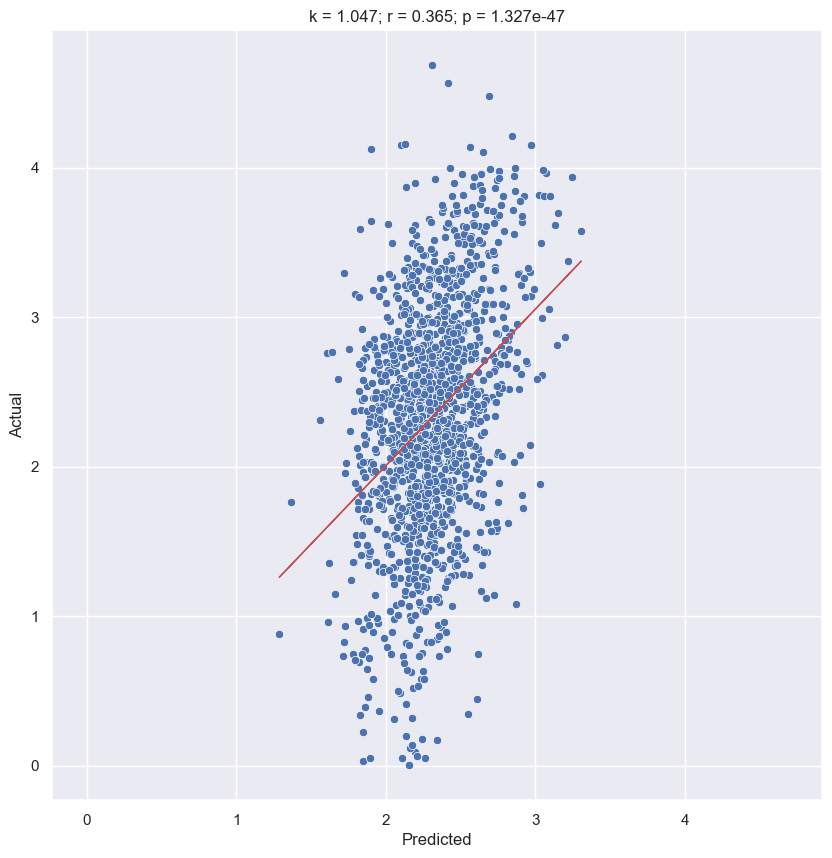

In [82]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_keep,
		order    = target_order,
		filename = os.path.join(OUT_PLOT2, model.__name__ + '-keep-best')
	)

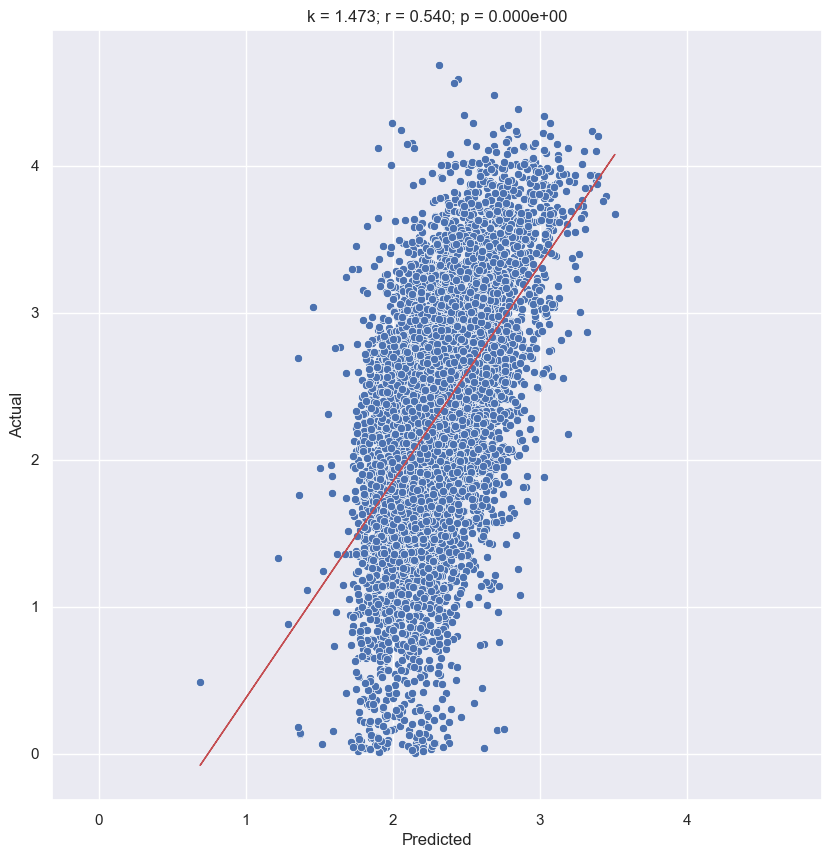

In [83]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_full,
		order    = target_order,
		filename = os.path.join(OUT_PLOT2, model.__name__ + '-full-best')
	)

## 4.4 Save

In [84]:
# Convert reports from numpy array to lists

def ensure_json_validity (item) :
	if   isinstance(item, dict)          : pass
	elif isinstance(item, list)          : return item
	elif isinstance(item, numpy.ndarray) : return item.tolist()
	elif isinstance(item, float)         : return item
	elif isinstance(item, int)           : return item
	elif isinstance(item, str)           : return item
	else                                 : return None

	data = dict()

	for key in item.keys() :
		data[key] = ensure_json_validity(item[key])

	return data

report_keep = ensure_json_validity(report_keep)
report_full = ensure_json_validity(report_full)

In [85]:
# Save results

for key, value in final_report.items() :
	if isinstance(value, numpy.float32) :
		final_report[key] = float(value)

writer.write_json(
	data     = final_report,
	filename = os.path.join(OUT_DATA2, 'report.json')
)

writer.write_json(
	data     = report_keep,
	filename = os.path.join(OUT_DATA2, 'report_keep.json')
)

writer.write_json(
	data     = report_full,
	filename = os.path.join(OUT_DATA2, 'report_full.json')
)

writer.write_json(
	data     = {k : v for k, v in CONFIG.items() if k != 'core/device'},
	filename = os.path.join(OUT_DATA2, 'config.json')
)